In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolTransforms
import py_rdl
import RA

# Cremer Pople Puckering Parameter

In [184]:
# Five
molecule = Chem.SDMolSupplier("molecule/unique.sdf",removeHs=False)
five = pd.read_csv("five.csv")

In [185]:
k = np.unique(five["idx"][:1000].values)

In [ ]:
[molecule[x] for x in k.tolist()]

In [192]:
result = []
oxygen_smarts = Chem.MolFromSmarts("[r5]!@-[OX2]")
doxygen_smarts = Chem.MolFromSmarts("[r5]=[O;!R]")
halogen_smarts = Chem.MolFromSmarts("[r5]!@-[Cl,I,Br;R]")
csmarts = Chem.MolFromSmarts("[C;R](=[O])@[N,O;R]")
for idx, mol in enumerate([molecule[x] for x in k.tolist()]):
    bonds = []
    omatches = mol.GetSubstructMatches(oxygen_smarts)
    domatches = mol.GetSubstructMatches(doxygen_smarts)
    hmatches = mol.GetSubstructMatches(halogen_smarts)
    cmatches = mol.GetSubstructMatches(csmarts)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==5:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                endotorsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%5,(i+1)%5,(i+2)%5,(i+3)%5]]) for i in range(5)]
                check = [(mat[0] in ringloop) and (mat[2] in ringloop) for mat in cmatches]
                for m in hmatches:
                    if m[0] in ringloop:
                        loc = ringloop.index(m[0])
                        exotorsion = rdMolTransforms.GetDihedralRad(mol.GetConformer(),m[1],m[0],ringloop[(loc+1)%5],ringloop[(loc+2)%5])
                        result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*endotorsion,any(check), loc, exotorsion, "H"))

                for m in domatches:
                    if m[0] in ringloop:
                        loc = ringloop.index(m[0])
                        exotorsion = rdMolTransforms.GetDihedralRad(mol.GetConformer(),m[1],m[0],ringloop[(loc+1)%5],ringloop[(loc+2)%5])
                        result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*endotorsion,any(check), loc, exotorsion, "D"))
                for m in omatches:
                    if m[0] in ringloop:
                        loc = ringloop.index(m[0])
                        exotorsion = rdMolTransforms.GetDihedralRad(mol.GetConformer(),m[1],m[0],ringloop[(loc+1)%5],ringloop[(loc+2)%5])
                        result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*endotorsion,any(check), loc, exotorsion, "O"))

            

In [195]:
outcome = pd.DataFrame(result)

In [216]:
dd = outcome[outcome.iloc[:,-1]=="O"]

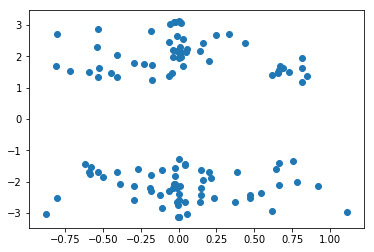

In [217]:
plt.scatter(dd.iloc[:,17],dd.iloc[:,20])

In [218]:
dd1 = dd[dd.iloc[:,3:8].sum(axis=1)==5]

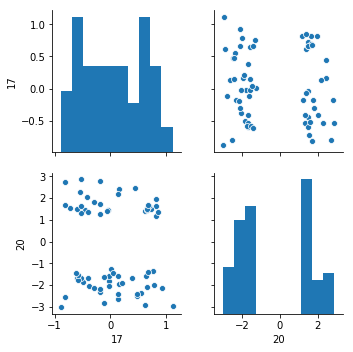

In [219]:
sns.pairplot(dd1[dd1.iloc[:,18]==False].iloc[:,[17,20]])

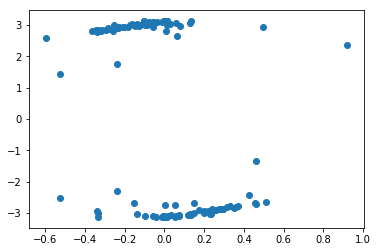

In [211]:
plt.scatter(dd1.iloc[:,17],dd1.iloc[:,20])

In [4]:
monocyclic = []
polycyclic = []
for idx, item in enumerate(five[["A0","A1","A2","A3","A4"]].values):
    if list(item)==["M","M","M","M","M"]:
        monocyclic.append(idx)
    else:
        polycyclic.append(idx)
        
mono_five = five.iloc[monocyclic].reset_index(drop=True)
poly_five = five.iloc[polycyclic].reset_index(drop=True)

mono_single = []
mono_one = []
mono_two = []
for idx, item in enumerate(mono_five[["B0","B1","B2","B3","B4"]].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        mono_single.append(idx)
    elif sum(check)==1:
        mono_one.append(idx)
    else:
        mono_two.append(idx)

poly_single = []
poly_one = []
poly_two = []
for idx, item in enumerate(poly_five[["B0","B1","B2","B3","B4"]].values):
    check = [x==1.5 or x==2.0 for x in list(item)]
    if sum(check)==0:
        poly_single.append(idx)
    elif sum(check)==1:
        poly_one.append(idx)
    else:
        poly_two.append(idx)

In [155]:
molecule = Chem.SDMolSupplier("molecule/unique.sdf",removeHs=False)

In [161]:
keep = []
inchis = []
for idx, mol in enumerate(molecule):
    inchi = Chem.MolToInchiKey(mol)
    bonds = []
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==9:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                atomtype = RA.GetRingAtomType(mol, ringloop)
                if inchi not in inchis:
                #if all([x=="M" for x in atomtype]) and (inchi not in inchis):
                    inchis.append(inchi)
                    keep.append(mol)

In [163]:
forteen = Chem.SDWriter("nine.sdf")
for mol in keep:
    forteen.write(mol)
forteen.close()

In [26]:
seven = Chem.SDWriter("seven_all.sdf")
for mol in keep:
    seven.write(mol)
seven.close()

In [5]:
molecule = Chem.SDMolSupplier("mono_five.sdf")

In [100]:
result = []
smarts = Chem.MolFromSmarts("[r5]!@-[!#1]")
#dsmarts = Chem.MolFromSmarts("[C;R1](=[O])@[!#1;R1]@[!#1;R1]")
storsions = []
for idx, mol in enumerate(molecule):
    bonds = []
    smatches = mol.GetSubstructMatches(smarts)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==5:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                torsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%5,(i+1)%5,(i+2)%5,(i+3)%5]]) for i in range(5) ]
                for m in smatches:
                    if m[0] in ringloop:
                        storsions.append((idx,bondtype,atomtype,ringloop.index(m[0]),cptmp[0][0],cptmp[1][0], *RA.GetRingSubstituentPosition(mol, ringloop, [m[0],m[1]])))
                #dtorsions = []
                #for m in dmatches:
                #    dtorsions.append([(ni, rdMolTransforms.GetDihedralRad(mol.GetConformer(),m[1], ringloop[ni],ringloop[(ni+1)%5],ringloop[(ni+2)%5]))])
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*torsion, dtorsions, storsions))


NameError: name 'molecule' is not defined

In [228]:
t = pd.DataFrame(storsions)

In [229]:
kidx = []
for idx in range(len(t)):
    check1 = [x==1.0 for x in t.iloc[idx,1]]
    check2 = [x=="M" for x in t.iloc[idx,2]]
    if all(check1) and all(check2):
        kidx.append(idx)

In [295]:
fil = t.iloc[kidx,:][t.iloc[kidx,3]==1]

In [359]:
fil1 = fil[fil.iloc[:,6]<0.8]

In [360]:
c1, c2 = fil1.iloc[:,4],fil1.iloc[:,5]
Y = fil1.iloc[:,6]

In [361]:
X = np.column_stack([np.ones(len(c1)), (c1**2)*np.cos(2*c2),(c1**2)*np.sin(2*c2), c1*np.cos(c2), c1*np.sin(c2)])

In [362]:
fil2 = fil[fil.iloc[:,6]>1.5]

In [364]:
xtx = np.linalg.inv(np.matmul(np.transpose(X),X))
xty = np.matmul(np.transpose(X),Y)
beta = np.matmul(xtx,xty)
xb = np.matmul(X,beta)

In [365]:
beta

array([ 0.61718693,  0.15071282, -0.21828034,  1.01143493,  0.59868938])

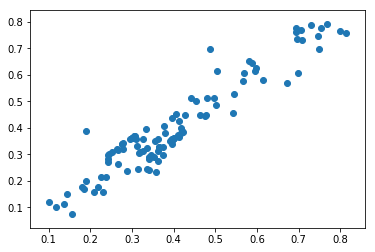

In [366]:
plt.scatter(xb,Y)

In [367]:
np.corrcoef(xb,Y)

array([[1.        , 0.94478294],
       [0.94478294, 1.        ]])

In [270]:
result = []
smarts = Chem.MolFromSmarts("[r5]([!#1])@[r5]@[r5]")
dsmarts = Chem.MolFromSmarts("[C;R1](=[O])@[!#1;R1]@[!#1;R1]")
for idx, mol in enumerate(molecule):
    bonds = []
    smatches = mol.GetSubstructMatches(smarts)
    dmatches = mol.GetSubstructMatches(dsmarts)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==5:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                torsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%5,(i+1)%5,(i+2)%5,(i+3)%5]]) for i in range(5) ]
                storsions = []
                for m in smatches:
                    if (m[0] in ringloop) and (m[2] in ringloop) and (m[3] in ringloop):
                        if (ringloop.index(m[0])<ringloop.index(m[2])) and (ringloop.index(m[2])<ringloop.index(m[3])):
                            ni = ringloop.index(m[0])
                            storsions.append([(ni, rdMolTransforms.GetDihedralRad(mol.GetConformer(),m[1], ringloop[ni],ringloop[(ni+1)%5],ringloop[(ni+2)%5]))])
                dtorsions = []
                for m in dmatches:
                    if (m[0] in ringloop) and (m[2] in ringloop) and (m[3] in ringloop):
                        if (ringloop.index(m[0])<ringloop.index(m[2])) and (ringloop.index(m[2])<ringloop.index(m[3])):
                            ni = ringloop.index(m[0])
                            dtorsions.append([(ni, rdMolTransforms.GetDihedralRad(mol.GetConformer(),m[1], ringloop[ni],ringloop[(ni+1)%5],ringloop[(ni+2)%5]))])
                #tmp =[]
                #for m in match:
                #    if (m[0] in ringloop) and (m[1] in ringloop) and (m[2] in ringloop) and (ringloop.index(m[2])>ringloop.index(m[1])):
                #         tmp.append((ringloop.index(m[2]), rdMolTransforms.GetDihedralRad(mol.GetConformer(), *m)))
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*torsion, dtorsions, storsions))


KeyboardInterrupt: 

In [ ]:
dtorsions

In [183]:
f = pd.DataFrame(result)

In [184]:
si = []
for idx, item in enumerate(f.iloc[:,8:13].values):
    check = [x=="M" for x in item]
    if all(check):
        si.append(idx)

g = f.iloc[si,:].reset_index(drop=True)
gi = []
for idx, item in enumerate(g.iloc[:,3:8].values):
    check = [x==1.0 for x in item]
    if all(check):
        gi.append(idx)
final = g.iloc[gi,:].reset_index(drop=True)

In [185]:
f1,f2,f3 = np.ones(len(final)), final.iloc[:,1]*np.cos(final.iloc[:,2]).values,final.iloc[:,1]*np.sin(final.iloc[:,2]).values
X = np.column_stack([f1,f2,f3])
Y = final.iloc[:,13].values

In [186]:
xtx = np.linalg.inv(np.matmul(np.transpose(X),X))
xty = np.matmul(np.transpose(X),Y)
beta = np.matmul(xtx,xty)

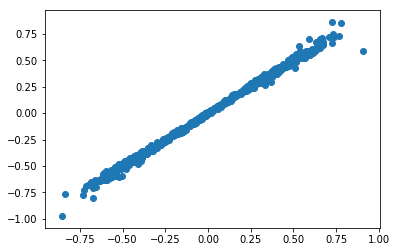

In [187]:
plt.scatter(np.matmul(X,beta),Y)

In [192]:
qi = []
for idx, item in enumerate(final.iloc[:,19].values):
    for x in item:
        if x[0][0]==1:
            qi.append((final.iloc[idx,0],x[0][1],*final.iloc[idx,13:18].values.tolist()))
            
    

In [17]:
a = pd.DataFrame(result)

k = []
for idx, i in enumerate(a.iloc[:,8:13].values):
    if list(i)==["M","M","M","M","M"]:
        k.append(idx)
        
b = a.iloc[k,:].reset_index(drop=True)

k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,3:7].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

In [18]:
qq = b.iloc[k0,:].reset_index(drop=True)

In [19]:
qqcp = qq.iloc[:,1:3]
qqt = qq.iloc[:,13:18]

In [20]:
Y = qqt.iloc[:,0]
X1 = np.array(qqcp.iloc[:,0]*np.cos(qqcp.iloc[:,1]))
X2 = np.array(qqcp.iloc[:,0]*np.sin(qqcp.iloc[:,1])) 

In [21]:
X = np.array([np.ones(len(X1)),X1,X2]).transpose()

In [22]:
xtx = np.linalg.inv(np.matmul(np.transpose(X),X))
xty = np.matmul(np.transpose(X),Y)

r = np.matmul(xtx,xty)

In [23]:
r

array([-7.67584045e-04,  1.06556925e+00,  1.45228565e+00])

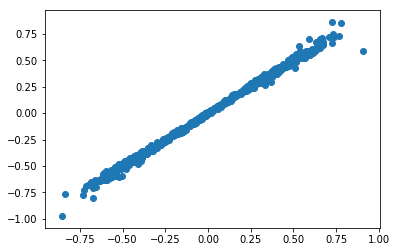

In [24]:
plt.scatter(np.matmul(X,np.transpose(np.matmul(xtx,xty))),Y)

In [25]:
Y2 = np.matmul(X,np.transpose(np.matmul(xtx,xty)))

In [26]:
k = []
w = []
for idx, item in enumerate(qq.iloc[:,18].values):
    for x in item:
        if x[0]==1:
            k.append(idx)
            w.append(x[1])

In [329]:
def EnumerateRingBond(mol, idxlist):
    """
    Enumerate bonds in a cycle

    Input:

    mol: rdMol

    idxlist: list (ring atoms)

    Return:

    ringbond: list of tuples [(atom_1, atom_2)]
    
    """
    ringbond = []
    size = len(idxlist)
    ringbond = [(idxlist[i%size],idxlist[(i+1)%size]) for i in range(size)]
    return ringbond

In [ ]:
def GetShareSingleBondAtomsInRing(mol):
    """
    Identify single bond shared by multiple ring systems

    Return:

    """
    edgelist = []
    for bond in mol.GetBonds():
        edgelist.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))
    data = py_rdl.Calculator.get_calculated_result(edgelist)
    rings = []
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            rcs = data.get_relevant_cycles_for_urf(urf)
            ringatoms = Rearrangement(mol,list(rc.nodes))
            rings.append([str(rc.urf),ringatoms])
    NumRCs = len(rings)
    # identify the atoms/single bonds that share in fused ring
    bridgehead_atoms = []
    bridgehead_set = list(set(bridgehead_atoms))
    # Check for Fused Ring/Bridge Ring Atoms
    for i in itertools.combinations(range(NumRCs),2):
        if rings[i[0]][0]!=rings[i[1]][0]:  # only consider unpaired URFs
            bondsetA = EnumerateRingBond(mol,rings[i[0]][1])
            bondsetB = EnumerateRingBond(mol,rings[i[1]][1])
            sorted_bondsetA = [tuple(sorted(ebond)) for ebond in bondsetA]
            sorted_bondsetB = [tuple(sorted(ebond)) for ebond in bondsetB]
            intersections = list(set(sorted_bondsetA).intersection(sorted_bondsetB))
            intersectionelement = [x for bondpair in intersections for x in bondpair]
            if any(intersections):
                if len(intersections)>1:
                    bridgering_element = list(set(intersectionelement))
                    for node in bridgering_element:
                        if intersectionelement.count(node)==1:
                            bridgehead_atoms.append(node)
            ringsintersection = list(set(rings[i[0]][1]).intersection(set(rings[i[1]][1])))
            if len(ringsintersection)==1:
                spiro_atoms.append(ringsintersection[0])
    bridgehead_set = list(set(bridgehead_atoms))
    return bridgehead_set



# Seven-membered Ring 

In [3]:
seven = Chem.SDMolSupplier("seven_all.sdf")

In [4]:
RA.GetRingElement(seven[1],[0,1,2,3,4,5,6])

[(0, 16), (1, 8), (2, 6), (3, 6), (4, 6), (5, 6), (6, 16)]

In [5]:
result1 = []
smarts_1 = Chem.MolFromSmarts("[R][O;R][C;R](=O)")
smarts_2 = Chem.MolFromSmarts("[R]1@[R]@[R]1")
smarts_3 = Chem.MolFromSmarts("[O;R][C,S;R][O;R]")

for idx, mol in enumerate(seven):
    bonds = []
    mat1 = mol.GetSubstructMatches(smarts_1)
    mat2 = mol.GetSubstructMatches(smarts_2)
    mat3 = mol.GetSubstructMatches(smarts_3)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==7:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                ringelement = [item[1] for item in RA.GetRingElement(mol, ringloop)]
                check1 = [mat[0] in ringloop for mat in mat1]
                check2 = [set(ringloop).intersection(set(mat)) for mat in mat2]
                check3 = [set(ringloop).intersection(set(mat)) for mat in mat3]
                result1.append((idx,*cptmp[0],*cptmp[1],*ringelement, *bondtype,*atomtype, any(check1), any(check2),
                               any(check3)))


In [8]:
outcome = pd.DataFrame(result1)

In [33]:
result = []
smarts_1 = Chem.MolFromSmarts("[C;R](=O)[O,N;R]")
smarts_2 = Chem.MolFromSmarts("[R]1@[R]@[R]1")
smarts_3 = Chem.MolFromSmarts("[O;R][C,S;R][O;R]")
smarts_4 = Chem.MolFromSmarts("[S;R][S;R]")
smarts_5 = Chem.MolFromSmarts("[P,Si;R]")
smarts_6 = Chem.MolFromSmarts("[R][O;R][C;R](=O)")
for idx, mol in enumerate(seven):
    bonds = []
    mat1 = mol.GetSubstructMatches(smarts_1)
    mat2 = mol.GetSubstructMatches(smarts_2)
    mat3 = mol.GetSubstructMatches(smarts_3)
    mat4 = mol.GetSubstructMatches(smarts_4)
    mat5 = mol.GetSubstructMatches(smarts_5)
    mat6 = mol.GetSubstructMatches(smarts_6)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==7:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                check1 = [set(ringloop).intersection(set(mat)) for mat in mat1]
                check2 = [set(ringloop).intersection(set(mat)) for mat in mat2]
                check3 = [set(ringloop).intersection(set(mat)) for mat in mat3]
                check4 = [set(ringloop).intersection(set(mat)) for mat in mat4]
                check5 = [set(ringloop).intersection(set(mat)) for mat in mat5]
                check6 = [set(ringloop).intersection(set(mat)) for mat in mat6]
                check7 = [mat[0] in ringloop for mat in mat7]
                check8 = [mat[0] in ringloop for mat in mat8]
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype, any(check1), any(check2), any(check3),
                               any(check4),any(check5), any(check6)))


In [265]:
seven_frame = pd.DataFrame(result1)
mono = []
poly = []
mono1 = []
poly1 = []
other = []
o1 = []
for idx in range(5686):
    check1 = [x==1.0 for x in seven_frame.iloc[idx,12:19].values]
    check2 = [x=="M" for x in seven_frame.iloc[idx,19:26].values]
    if all(check1) and all(check2):
        mono.append(idx)
    elif all(check1) and not all(check2):
        poly.append(idx)
    elif sum(check1)==6 and all(check2):
        mono1.append(idx)
    elif sum(check1)==6 and not all(check2):
        poly1.append(idx)
    elif sum(check1)==5:
        other.append(idx)
    elif sum(check1)==4:
        o1.append(idx)

In [352]:
seven_frame.to_csv("seven_check.csv",index=None)

In [316]:
p4 = seven_frame.iloc[other,:]

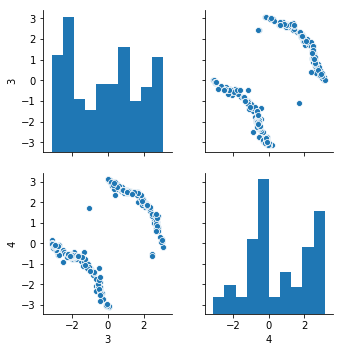

In [325]:
sns.pairplot(p4[p4.iloc[:,15]!=1.0].iloc[:,3:5])

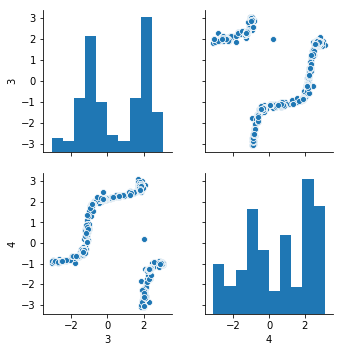

In [324]:
sns.pairplot(p4[p4.iloc[:,14]!=1.0].iloc[:,3:5])

(array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  9.,  0.,  6.,  0.,  8.,  4.,  4.,  6.,  2.,  8., 25.,
        15., 40., 21., 16.,  8., 13., 29., 17., 20., 15., 12., 17.,  6.,
        22., 10.,  7.,  3.,  0., 10.,  5.,  1.,  1.,  1.,  3.]),
 array([8.92537533e-04, 2.54669081e-02, 5.00412786e-02, 7.46156491e-02,
        9.91900196e-02, 1.23764390e-01, 1.48338761e-01, 1.72913131e-01,
        1.97487502e-01, 2.22061872e-01, 2.46636243e-01, 2.71210613e-01,
        2.95784984e-01, 3.20359354e-01, 3.44933725e-01, 3.69508095e-01,
        3.94082466e-01, 4.18656836e-01, 4.43231207e-01, 4.67805577e-01,
        4.92379948e-01, 5.16954318e-01, 5.41528689e-01, 5.66103059e-01,
        5.90677430e-01, 6.15251801e-01, 6.39826171e-01, 6.64400542e-01,
        6.88974912e-01, 7.13549283e-01, 7.38123653e-01, 7.62698024e-01,
        7.87272394e-01, 8.11846765e-01, 8.36421135e-01, 8.60995506e-01,
        8.85569876e-01, 9.10144247e-01, 9.34718617e-01, 9.59292988e-

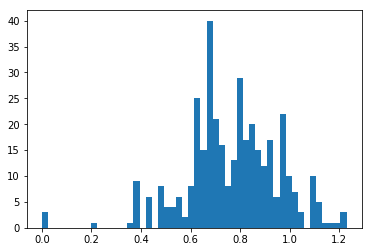

In [350]:
plt.hist(np.sqrt(p4[p4.iloc[:,15]!=1.0].iloc[:,1:3].apply(np.square).sum(axis=1)),bins=50)

(array([  3.,   0.,   0.,   0.,   1.,   0.,   2.,   0.,   1.,   2.,   1.,
          2.,   3.,   7.,   6.,  22.,  15.,  34.,  17.,  27.,  46.,  32.,
         54.,  32.,  42.,  43.,  35.,  45.,  37.,  37.,  41.,  41.,  10.,
         14.,  12.,  27.,  31.,   5.,   7.,  30., 106.,   3.,   2.,   2.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.18331882, 0.20708997, 0.23086112, 0.25463226, 0.27840341,
        0.30217455, 0.3259457 , 0.34971685, 0.37348799, 0.39725914,
        0.42103028, 0.44480143, 0.46857258, 0.49234372, 0.51611487,
        0.53988601, 0.56365716, 0.5874283 , 0.61119945, 0.6349706 ,
        0.65874174, 0.68251289, 0.70628403, 0.73005518, 0.75382633,
        0.77759747, 0.80136862, 0.82513976, 0.84891091, 0.87268206,
        0.8964532 , 0.92022435, 0.94399549, 0.96776664, 0.99153779,
        1.01530893, 1.03908008, 1.06285122, 1.08662237, 1.11039351,
        1.13416466, 1.15793581, 1.18170695, 1.2054781 , 1.22924924,
        1.25302039, 1.27679154, 1.30056268, 1.

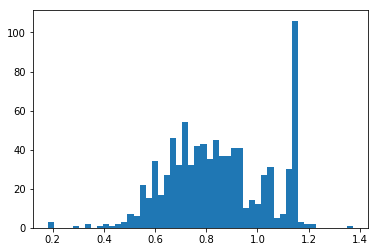

In [349]:
plt.hist(np.sqrt(p4[p4.iloc[:,14]!=1.0].iloc[:,1:3].apply(np.square).sum(axis=1)),bins=50)

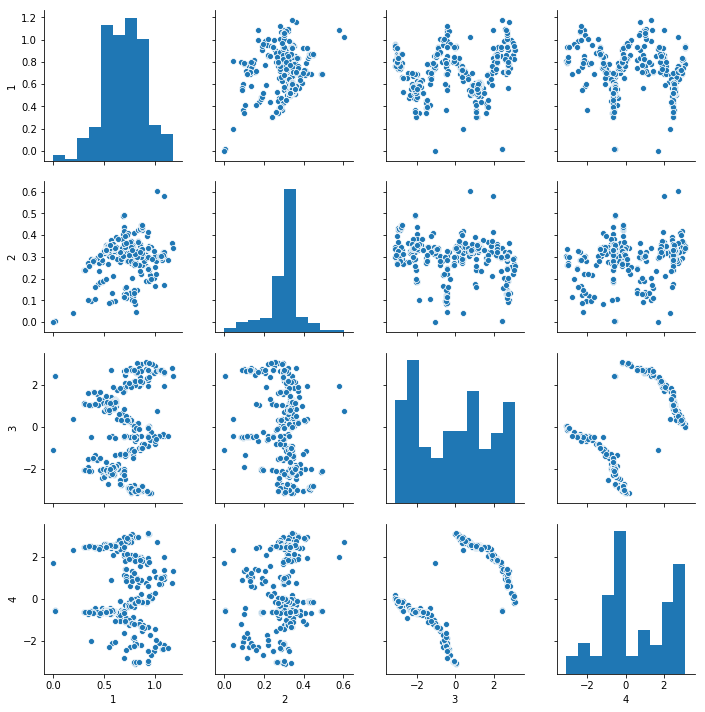

In [342]:
sns.pairplot(p4[p4.iloc[:,15]!=1.0].iloc[:,1:5])

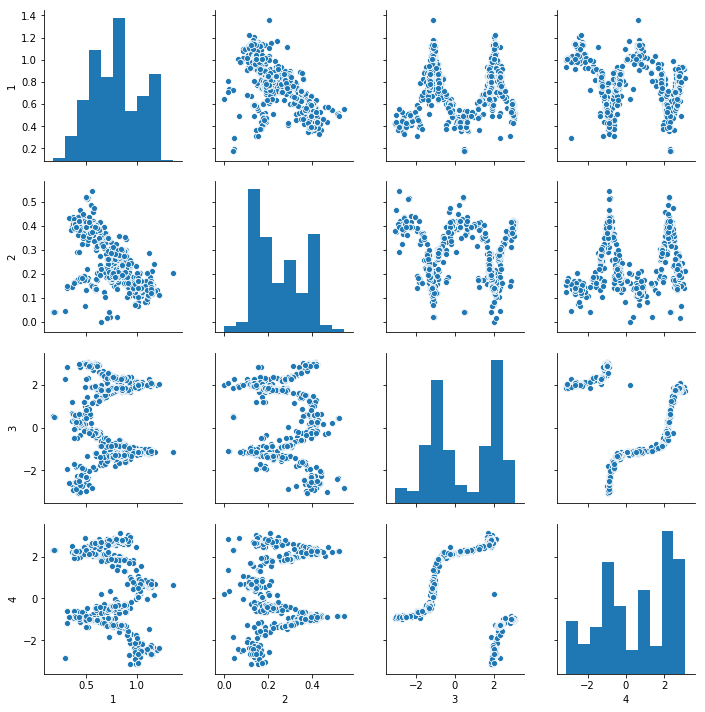

In [341]:
sns.pairplot(p4[p4.iloc[:,14]!=1.0].iloc[:,1:5])

In [339]:
p4[(p4.iloc[:,14]!=1.0)  & (p4.iloc[:,3]>1.5) & (p4.iloc[:,4]>-0.5)  & (p4.iloc[:,4]<1.5)]

0         1         2        3         4   5   6   7   8   9   ...    \
1236  1105  0.650487  0.001324  2.01708  0.200607   6   6   6   6   6  ...     

      19  20  21  22  23  24  25     26     27     28  
1236   B   B   B   B   M   M   M  False  False  False  

[1 rows x 29 columns]

In [333]:
p4[(p4.iloc[:,14]!=1.0)].iloc[:,3]>1

0        True
6        True
8       False
36       True
48      False
69      False
80      False
84      False
99       True
106      True
108     False
120     False
123     False
132     False
150     False
153      True
159     False
174      True
187     False
189     False
199     False
213     False
225     False
228     False
231     False
234     False
239      True
242      True
259     False
293     False
        ...  
5444    False
5446    False
5452    False
5453    False
5465     True
5476     True
5491     True
5492     True
5493    False
5494    False
5495     True
5496    False
5497    False
5498    False
5501     True
5521    False
5522    False
5544     True
5545    False
5570    False
5579    False
5582     True
5621    False
5627    False
5629    False
5630    False
5639    False
5658     True
5660    False
5661    False
Name: 3, Length: 878, dtype: bool

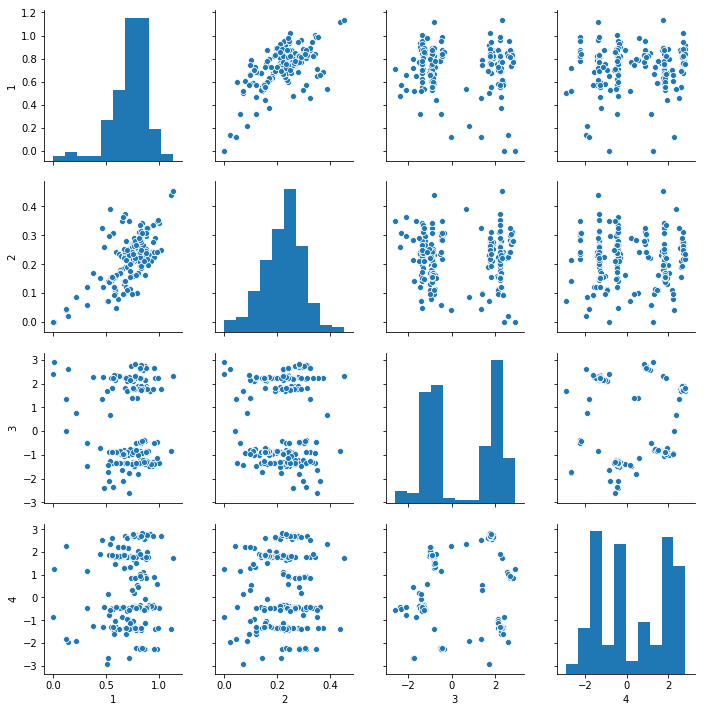

In [311]:
sns.pairplot(p4.iloc[:,1:5])

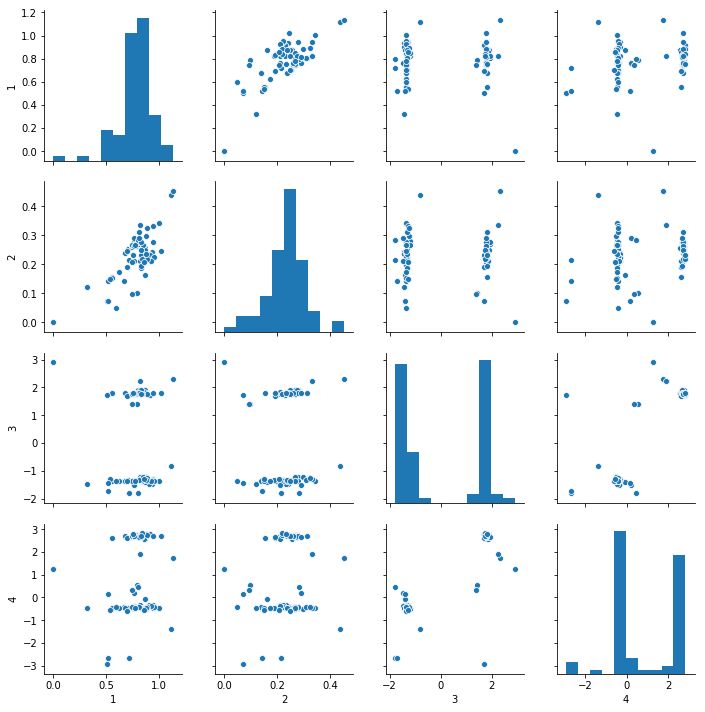

In [302]:
sns.pairplot(p4[p4.iloc[:,16]!=1.0].iloc[:,1:5])

In [294]:
p4.iloc[211,12:19]

12      2
13      1
14      2
15      1
16      1
17    1.5
18      1
Name: 4814, dtype: object

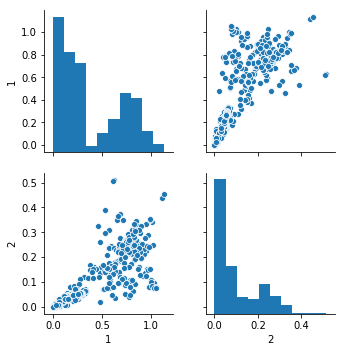

In [271]:
sns.pairplot(p4.iloc[:,1:3])

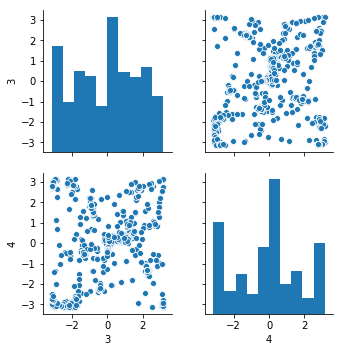

In [266]:
sns.pairplot(p4.iloc[:,3:5])

In [261]:
p4 = seven_frame.iloc[o1]

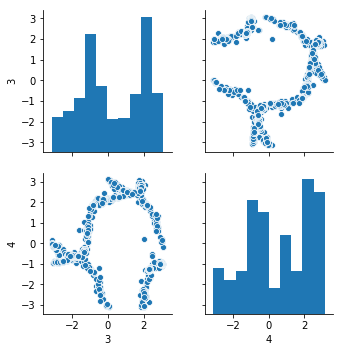

In [252]:
sns.pairplot(p2.iloc[:,3:5])

In [253]:
p1 = seven_frame.iloc[mono1+poly1][(seven_frame.iloc[mono1+poly1].iloc[:,1]<0.6)]
p2 = seven_frame.iloc[mono1+poly1][(seven_frame.iloc[mono1+poly1].iloc[:,1]>0.6)]
p3 = seven_frame.iloc[other]

(array([  3.,   0.,   0.,   0.,   0.,   0.,   2.,   3.,   1.,   1.,   2.,
         10.,   8.,  16.,  28.,  24.,  22.,  25.,  35.,  48.,  63.,  93.,
         47.,  30.,  22.,  43.,  48.,  60.,  56.,  77.,  57.,  69.,  50.,
         29.,  35.,  10.,  23.,  31.,  36.,  16.,  14., 111.,  22.,   3.,
          1.,   1.,   0.,   0.,   0.,   1.]),
 array([8.92076205e-04, 2.80070499e-02, 5.51220237e-02, 8.22369974e-02,
        1.09351971e-01, 1.36466945e-01, 1.63581919e-01, 1.90696892e-01,
        2.17811866e-01, 2.44926840e-01, 2.72041813e-01, 2.99156787e-01,
        3.26271761e-01, 3.53386735e-01, 3.80501708e-01, 4.07616682e-01,
        4.34731656e-01, 4.61846630e-01, 4.88961603e-01, 5.16076577e-01,
        5.43191551e-01, 5.70306524e-01, 5.97421498e-01, 6.24536472e-01,
        6.51651446e-01, 6.78766419e-01, 7.05881393e-01, 7.32996367e-01,
        7.60111341e-01, 7.87226314e-01, 8.14341288e-01, 8.41456262e-01,
        8.68571235e-01, 8.95686209e-01, 9.22801183e-01, 9.49916157e-01,
        9.

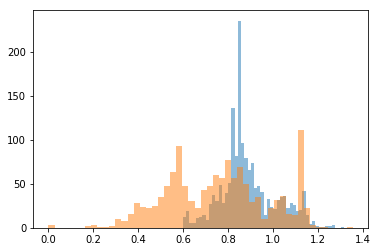

In [258]:
plt.hist(p2.iloc[:,1],bins=50,alpha=.5)
plt.hist(p3.iloc[:,1],bins=50,alpha=.5)

(array([ 4.,  3.,  0.,  7.,  0.,  3.,  3.,  7., 12., 25., 78., 90., 51.,
        25., 39., 58., 34., 34., 24., 32., 22., 24., 36., 58., 72., 40.,
        40., 52., 79., 53., 26., 28., 70., 58., 29.,  7., 12.,  5.,  5.,
         5.,  8.,  5.,  5.,  1.,  1.,  2.,  2.,  0.,  1.,  1.]),
 array([2.86930652e-05, 1.20786054e-02, 2.41285178e-02, 3.61784302e-02,
        4.82283425e-02, 6.02782549e-02, 7.23281672e-02, 8.43780796e-02,
        9.64279920e-02, 1.08477904e-01, 1.20527817e-01, 1.32577729e-01,
        1.44627641e-01, 1.56677554e-01, 1.68727466e-01, 1.80777378e-01,
        1.92827291e-01, 2.04877203e-01, 2.16927116e-01, 2.28977028e-01,
        2.41026940e-01, 2.53076853e-01, 2.65126765e-01, 2.77176677e-01,
        2.89226590e-01, 3.01276502e-01, 3.13326414e-01, 3.25376327e-01,
        3.37426239e-01, 3.49476152e-01, 3.61526064e-01, 3.73575976e-01,
        3.85625889e-01, 3.97675801e-01, 4.09725713e-01, 4.21775626e-01,
        4.33825538e-01, 4.45875450e-01, 4.57925363e-01, 4.69975275e-

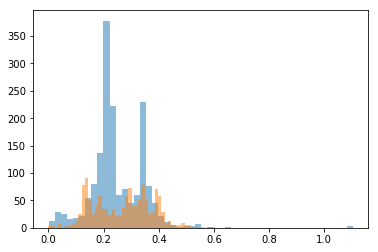

In [259]:
plt.hist(p2.iloc[:,2],bins=50,alpha=.5)
plt.hist(p3.iloc[:,2],bins=50,alpha=.5)

(array([  3.,   0.,   1.,   0.,   1.,   0.,   3.,   2.,   3.,   0.,   0.,
          7.,   3.,   3.,   3.,   4.,  14.,  63.,  92.,  15.,  12.,   4.,
          5.,   7.,   0.,   1.,   1.,   2.,   1.,   0.,   0.,   0.,   2.,
          1.,   0.,   2.,   3.,   2.,   1.,   4.,   4.,  15.,  22., 112.,
         64.,   6.,   5.,   4.,   7.,   3.]),
 array([-3.13556775, -3.01184988, -2.88813202, -2.76441416, -2.6406963 ,
        -2.51697844, -2.39326057, -2.26954271, -2.14582485, -2.02210699,
        -1.89838913, -1.77467126, -1.6509534 , -1.52723554, -1.40351768,
        -1.27979982, -1.15608195, -1.03236409, -0.90864623, -0.78492837,
        -0.6612105 , -0.53749264, -0.41377478, -0.29005692, -0.16633906,
        -0.04262119,  0.08109667,  0.20481453,  0.32853239,  0.45225025,
         0.57596812,  0.69968598,  0.82340384,  0.9471217 ,  1.07083956,
         1.19455743,  1.31827529,  1.44199315,  1.56571101,  1.68942887,
         1.81314674,  1.9368646 ,  2.06058246,  2.18430032,  2.30801818,
 

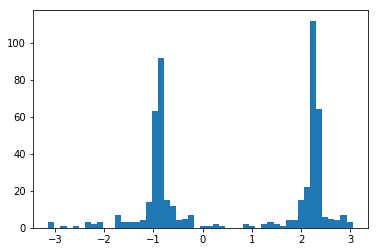

In [240]:
plt.hist(p1.iloc[:,3],bins=50)

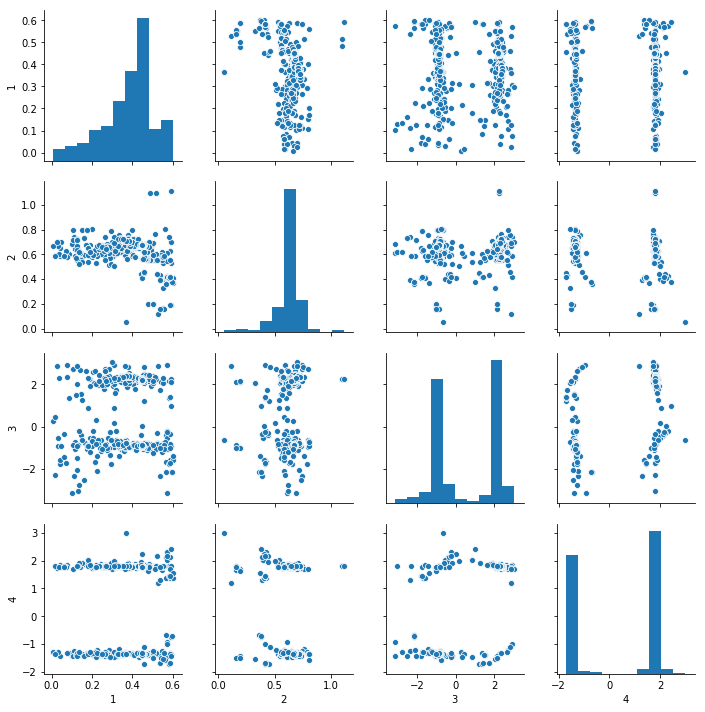

In [234]:
sns.pairplot(p1.iloc[:,1:5])

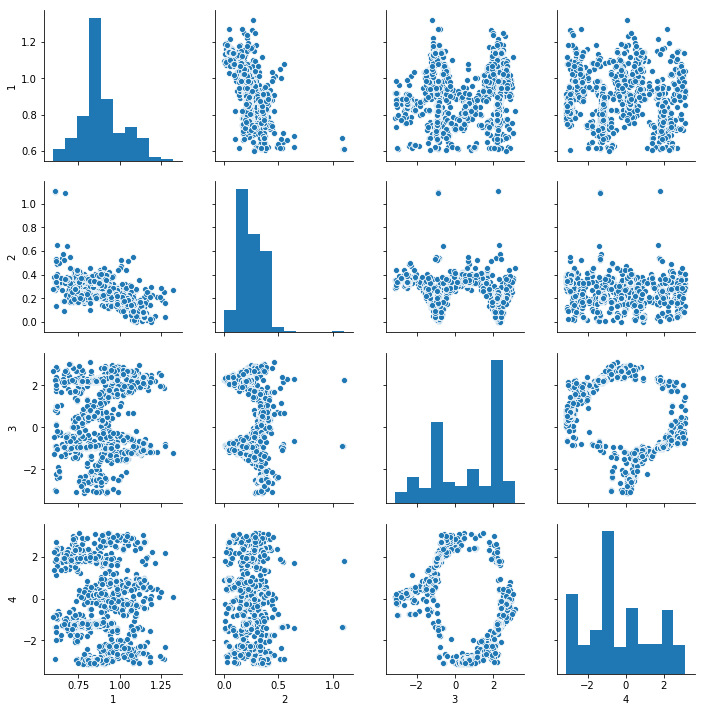

In [233]:
sns.pairplot(p2.iloc[:,1:5])

In [227]:
p1.iloc[:,5:19]

5   6   7   8   9   10  11   12   13   14   15   16   17   18
33     6   6   6   7   6   7   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
160    6   6   6   6   7   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
262    6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
290    6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
291    6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
642    6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
661    6   6   7   6   6   6   8  2.0  1.0  1.0  1.0  1.0  1.0  1.0
743    6   6   6   8   6   6   8  2.0  1.0  1.0  1.0  1.0  1.0  1.0
790    6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
893    6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
894    6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
895    6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
1088   6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
1193   6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
1230   6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
1395   6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
1564   6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
1638   6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
1647   6   6   7   6   7   6   7  2.0  1.0  1.0  1.0  1.0  1.0  1.0
1728   6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
1885   6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
2181   6   6   6   6   6   6   6  2.0  1.0  1.0  1.0  1.0  1.0  1.0
46     6   6   6   6   7   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
51     6   6   6   7   6   7   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
52     6   6   6   7   6   7   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
73     6   6   6   6   7  16   8  1.5  1.0  1.0  1.0  1.0  1.0  1.0
82     6   6   6   6   6   7   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
90     6   7   6   6   6   6   7  2.0  1.0  1.0  1.0  1.0  1.0  1.0
96     7   6   6   8   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
101    6   6   6   6   6   6   8  1.5  1.0  1.0  1.0  1.0  1.0  1.0
...   ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...
5174   6   7   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5251   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5252   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5288   6   6   8   6   6   6   8  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5337   6   6   6   7   6   6   7  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5459   6   6   8   6   6   6   8  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5503   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5510   7   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5515   6   7   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5529   7   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5540   6   6   7   6   6   6   7  2.0  1.0  1.0  1.0  1.0  1.0  1.0
5541   6   6   7   6   6   6   7  2.0  1.0  1.0  1.0  1.0  1.0  1.0
5590   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5602   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5622   6   6   6   7   6   6   7  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5631   6   6   8   6   6   6   8  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5641   6   6   7   6   6   6   7  2.0  1.0  1.0  1.0  1.0  1.0  1.0
5642   6   6   7   6   6   6   7  2.0  1.0  1.0  1.0  1.0  1.0  1.0
5643   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5644   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5645   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5646   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5647   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5648   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5650   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5651   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0  1.0
5653   6   6   6   6   6   6   6  1.5  1.0  1.0  1.0  1.0  1.0

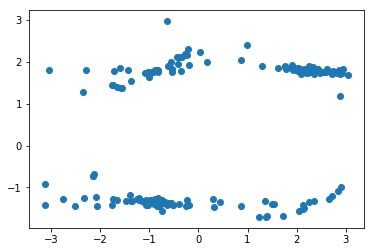

In [223]:
plt.scatter(p1.iloc[:,3],p1.iloc[:,4])

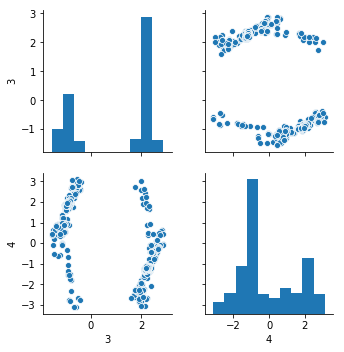

In [202]:
sns.pairplot(seven_frame.iloc[mono1+poly1][(seven_frame.iloc[mono1+poly1].iloc[:,1]>0.6) & (seven_frame.iloc[mono1+poly1].iloc[:,2]<0.25)].iloc[:,3:5])
plt.show()

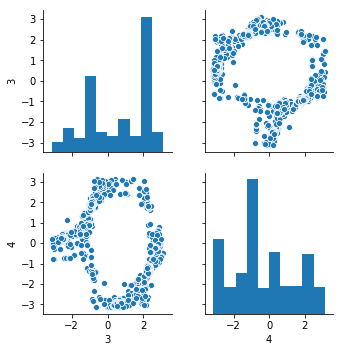

In [197]:
sns.pairplot(seven_frame.iloc[mono1+poly1][seven_frame.iloc[mono1+poly1].iloc[:,1]>0.6].iloc[:,3:5])
plt.show()

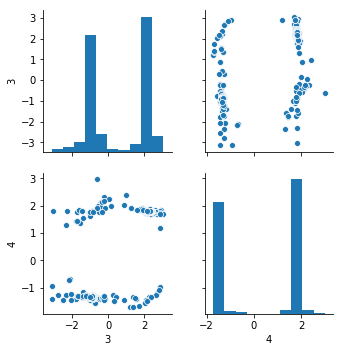

In [195]:
sns.pairplot(seven_frame.iloc[mono1+poly1][seven_frame.iloc[mono1+poly1].iloc[:,1]<0.6].iloc[:,3:5])
plt.show()

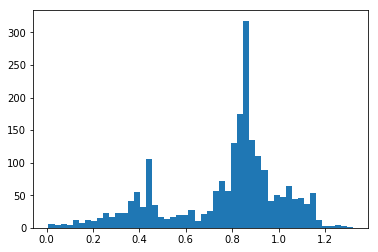

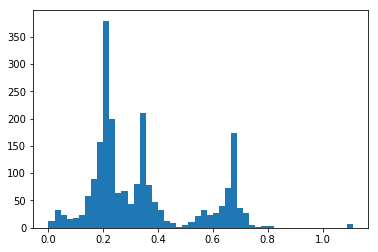

In [191]:
plt.hist(seven_frame.iloc[mono1+poly1].iloc[:,1],bins=50)
plt.show()
plt.hist(seven_frame.iloc[mono1+poly1].iloc[:,2],bins=50)
plt.show()

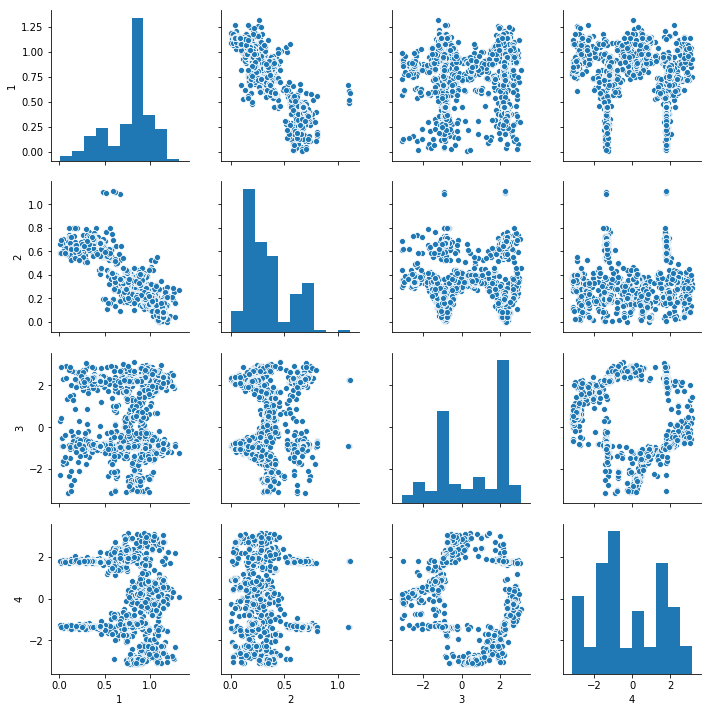

In [186]:
sns.pairplot(seven_frame.iloc[poly1].iloc[:,1:5])

(array([  3.,   0.,   0.,   0.,   0.,   0.,   2.,   3.,   1.,   1.,   2.,
         10.,   8.,  16.,  28.,  24.,  22.,  25.,  35.,  48.,  63.,  93.,
         47.,  30.,  22.,  43.,  48.,  60.,  56.,  77.,  57.,  69.,  50.,
         29.,  35.,  10.,  23.,  31.,  36.,  16.,  14., 111.,  22.,   3.,
          1.,   1.,   0.,   0.,   0.,   1.]),
 array([8.92076205e-04, 2.80070499e-02, 5.51220237e-02, 8.22369974e-02,
        1.09351971e-01, 1.36466945e-01, 1.63581919e-01, 1.90696892e-01,
        2.17811866e-01, 2.44926840e-01, 2.72041813e-01, 2.99156787e-01,
        3.26271761e-01, 3.53386735e-01, 3.80501708e-01, 4.07616682e-01,
        4.34731656e-01, 4.61846630e-01, 4.88961603e-01, 5.16076577e-01,
        5.43191551e-01, 5.70306524e-01, 5.97421498e-01, 6.24536472e-01,
        6.51651446e-01, 6.78766419e-01, 7.05881393e-01, 7.32996367e-01,
        7.60111341e-01, 7.87226314e-01, 8.14341288e-01, 8.41456262e-01,
        8.68571235e-01, 8.95686209e-01, 9.22801183e-01, 9.49916157e-01,
        9.

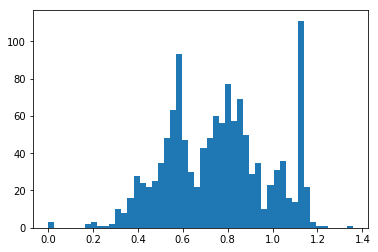

In [174]:
plt.hist(seven_frame.iloc[other].iloc[:,1],bins=50)

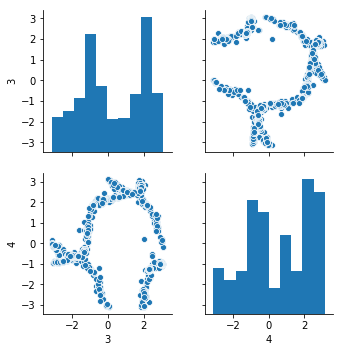

In [176]:
sns.pairplot(seven_frame.iloc[other].iloc[:,3:5])

(array([190., 165., 169.,  47.,  52., 143., 217., 159., 242., 466., 315.,
        123., 181., 174., 152., 358., 137., 162., 102.,  32.,  19.,   9.,
         18.,  15.,  21.,  36.,  26.,  27.,  41.,  71., 174.,  37.,  28.,
          5.,   2.,   4.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   7.]),
 array([9.36191819e-06, 2.22083171e-02, 4.44072724e-02, 6.66062276e-02,
        8.88051828e-02, 1.11004138e-01, 1.33203093e-01, 1.55402049e-01,
        1.77601004e-01, 1.99799959e-01, 2.21998914e-01, 2.44197869e-01,
        2.66396825e-01, 2.88595780e-01, 3.10794735e-01, 3.32993690e-01,
        3.55192646e-01, 3.77391601e-01, 3.99590556e-01, 4.21789511e-01,
        4.43988466e-01, 4.66187422e-01, 4.88386377e-01, 5.10585332e-01,
        5.32784287e-01, 5.54983243e-01, 5.77182198e-01, 5.99381153e-01,
        6.21580108e-01, 6.43779064e-01, 6.65978019e-01, 6.88176974e-01,
        7.10375929e-01, 7.32574884e-01, 7.54773840e-01, 7.76972795e-01,
        7.

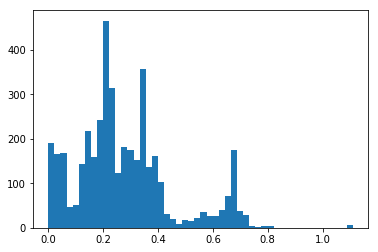

In [140]:
plt.hist(seven_frame.iloc[other].iloc[:,2],bins=50)

/home/lucian/anaconda3/envs/Chem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


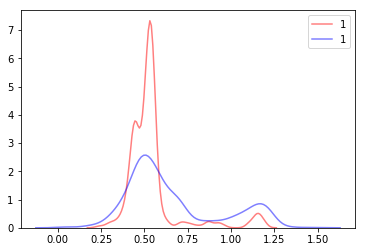

In [50]:
sns.kdeplot(seven_frame.iloc[mono].iloc[:,1],color="red",alpha=.5)
#sns.kdeplot(seven_frame.iloc[mono].iloc[:,2],color="red",alpha=.5)

sns.kdeplot(seven_frame.iloc[poly].iloc[:,1],color="blue",alpha=.5)
#sns.kdeplot(seven_frame.iloc[poly].iloc[:,2],color="blue",alpha=.5)
plt.show()

/home/lucian/anaconda3/envs/Chem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


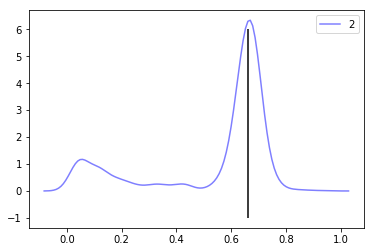

In [110]:

#sns.kdeplot(seven_frame.iloc[poly].iloc[:,1],color="blue",alpha=.5)
sns.kdeplot(seven_frame.iloc[poly].iloc[:,2],color="blue",alpha=.5)
plt.vlines(0.66,-1,6)

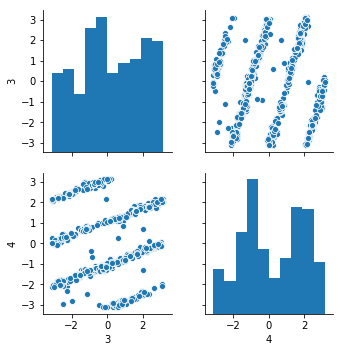

In [65]:
sns.pairplot(seven_frame.iloc[poly][(seven_frame.iloc[poly].iloc[:,1]<0.7) ].iloc[:,3:5])

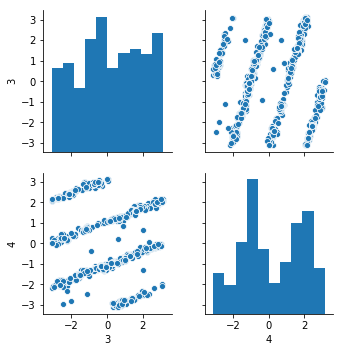

In [67]:
sns.pairplot(seven_frame.iloc[poly][(seven_frame.iloc[poly].iloc[:,1]<0.7) & (seven_frame.iloc[poly].iloc[:,27]==False)].iloc[:,3:5])

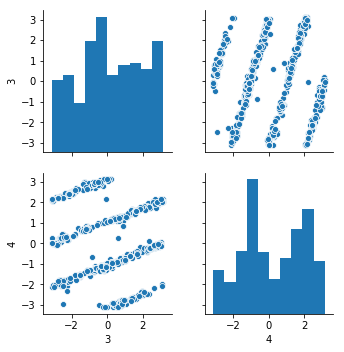

In [79]:
sns.pairplot(q.iloc[:,3:5])

In [94]:
q = seven_frame.iloc[poly][(seven_frame.iloc[poly].iloc[:,2]<0.45)]

(array([ 3.,  5.,  6., 10.,  3.,  2.,  2.,  6.,  9.,  7.,  7.,  3.,  3.,
        23., 12.,  5.,  4.,  4.,  6., 23.,  7.,  0.,  9.,  3.,  3.,  3.,
         7.,  2.,  8.,  5.,  3.,  3.,  7., 10., 11.,  6.,  7.,  4.,  7.,
         4.,  5.,  3.,  2.,  9.,  0.,  4.,  2.,  3., 13.,  6.]),
 array([0.01107276, 0.13605558, 0.2610384 , 0.38602122, 0.51100403,
        0.63598685, 0.76096967, 0.88595249, 1.01093531, 1.13591813,
        1.26090095, 1.38588377, 1.51086659, 1.63584941, 1.76083223,
        1.88581505, 2.01079787, 2.13578069, 2.26076351, 2.38574633,
        2.51072915, 2.63571197, 2.76069478, 2.8856776 , 3.01066042,
        3.13564324, 3.26062606, 3.38560888, 3.5105917 , 3.63557452,
        3.76055734, 3.88554016, 4.01052298, 4.1355058 , 4.26048862,
        4.38547144, 4.51045426, 4.63543708, 4.7604199 , 4.88540272,
        5.01038554, 5.13536835, 5.26035117, 5.38533399, 5.51031681,
        5.63529963, 5.76028245, 5.88526527, 6.01024809, 6.13523091,
        6.26021373]),
 <a list of 50

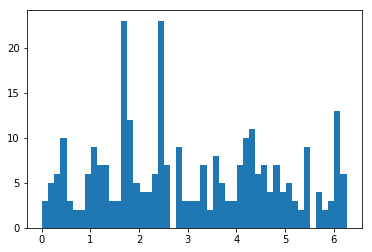

In [99]:
plt.hist(np.mod(q.iloc[:,3]-q.iloc[:,4],2*np.pi),bins=50)

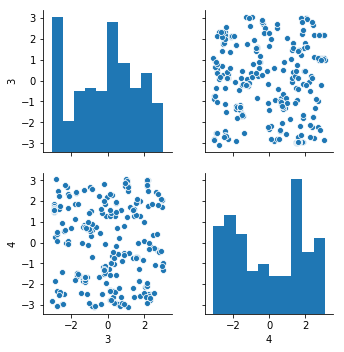

In [95]:
sns.pairplot(q.iloc[:,3:5])

In [111]:
q = seven_frame.iloc[poly][(seven_frame.iloc[poly].iloc[:,1]<0.7) &(seven_frame.iloc[poly].iloc[:,1]>0.4) &(seven_frame.iloc[poly].iloc[:,2]>0.45)]

In [116]:
q1 = seven_frame.iloc[poly][((seven_frame.iloc[poly].iloc[:,1]>0.7) | (seven_frame.iloc[poly].iloc[:,1]<0.4)) &(seven_frame.iloc[poly].iloc[:,2]<0.45)]

In [132]:
len(q)

734

In [133]:
q.iloc[:,28].sum()

68

In [129]:
q1.iloc[:,27].sum()

65

In [134]:
q1.iloc[:,28].sum()

72

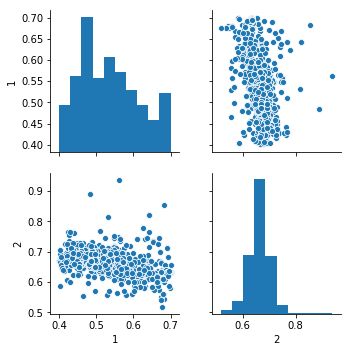

In [119]:
sns.pairplot(q.iloc[:,1:3])

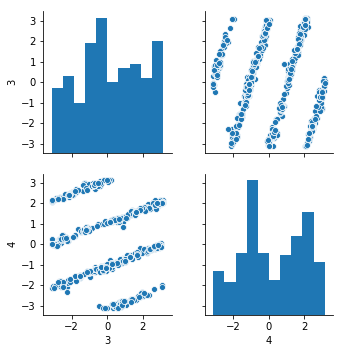

In [90]:
sns.pairplot(q.iloc[:,3:5])

(array([  2.,   3.,   4.,  20.,  64.,  47., 142.,  17.,   5.,   1.]),
 array([0.23763692, 0.2832299 , 0.32882287, 0.37441585, 0.42000882,
        0.46560179, 0.51119477, 0.55678774, 0.60238072, 0.64797369,
        0.69356667]),
 <a list of 10 Patch objects>)

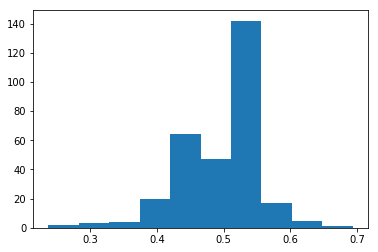

In [75]:
plt.hist(seven_frame.iloc[mono][seven_frame.iloc[mono].iloc[:,1]<0.7].iloc[:,1])

(array([  1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
          1.,   2.,   6.,   8.,  12.,  17.,  33.,  89.,  71., 125., 151.,
        107.,  53.,  28.,   9.,  10.,   5.,   1.,   0.,   1.,   2.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.]),
 array([0.18508992, 0.20013008, 0.21517024, 0.2302104 , 0.24525056,
        0.26029072, 0.27533089, 0.29037105, 0.30541121, 0.32045137,
        0.33549153, 0.35053169, 0.36557185, 0.38061201, 0.39565217,
        0.41069233, 0.42573249, 0.44077265, 0.45581281, 0.47085297,
        0.48589313, 0.50093329, 0.51597345, 0.53101361, 0.54605377,
        0.56109393, 0.57613409, 0.59117425, 0.60621441, 0.62125457,
        0.63629473, 0.65133489, 0.66637505, 0.68141521, 0.69645537,
        0.71149553, 0.72653569, 0.74157585, 0.75661601, 0.77165617,
        0.78669633, 0.80173649, 0.81677665, 0.83181681, 0.84685698,
        0.86189714, 0.8769373 , 0.89197746, 0.

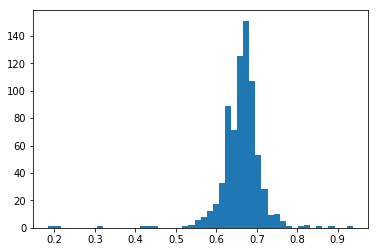

In [83]:
plt.hist(q.iloc[:,2],bins=50)

(array([  1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
          1.,   2.,   6.,   8.,  12.,  17.,  33.,  89.,  71., 125., 151.,
        107.,  53.,  28.,   9.,  10.,   5.,   1.,   0.,   1.,   2.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.]),
 array([0.18508992, 0.20013008, 0.21517024, 0.2302104 , 0.24525056,
        0.26029072, 0.27533089, 0.29037105, 0.30541121, 0.32045137,
        0.33549153, 0.35053169, 0.36557185, 0.38061201, 0.39565217,
        0.41069233, 0.42573249, 0.44077265, 0.45581281, 0.47085297,
        0.48589313, 0.50093329, 0.51597345, 0.53101361, 0.54605377,
        0.56109393, 0.57613409, 0.59117425, 0.60621441, 0.62125457,
        0.63629473, 0.65133489, 0.66637505, 0.68141521, 0.69645537,
        0.71149553, 0.72653569, 0.74157585, 0.75661601, 0.77165617,
        0.78669633, 0.80173649, 0.81677665, 0.83181681, 0.84685698,
        0.86189714, 0.8769373 , 0.89197746, 0.

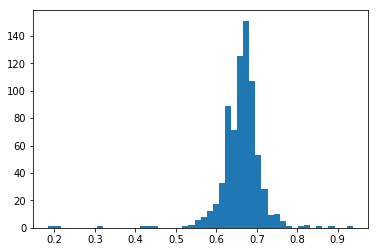

In [82]:
plt.hist(q.iloc[:,2],bins=50)

(array([  2.,   1.,   0.,   3.,   9., 184., 593.,  72.,   4.,   2.]),
 array([0.18508992, 0.26029072, 0.33549153, 0.41069233, 0.48589313,
        0.56109393, 0.63629473, 0.71149553, 0.78669633, 0.86189714,
        0.93709794]),
 <a list of 10 Patch objects>)

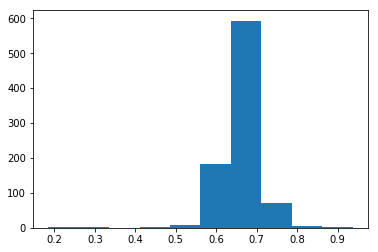

In [71]:
plt.hist(q.iloc[:,2])

(array([ 3.,  5.,  5.,  9.,  3.,  2.,  2.,  6.,  9.,  7.,  7.,  3.,  3.,
        23., 12.,  5.,  4.,  4.,  6., 23.,  6.,  0.,  9.,  3.,  3.,  3.,
         7.,  2.,  4.,  5.,  3.,  3.,  5., 10., 10.,  6.,  7.,  4.,  7.,
         4.,  5.,  3.,  2., 10.,  0.,  4.,  2.,  3., 12.,  6.]),
 array([0.01107276, 0.13605558, 0.2610384 , 0.38602122, 0.51100403,
        0.63598685, 0.76096967, 0.88595249, 1.01093531, 1.13591813,
        1.26090095, 1.38588377, 1.51086659, 1.63584941, 1.76083223,
        1.88581505, 2.01079787, 2.13578069, 2.26076351, 2.38574633,
        2.51072915, 2.63571197, 2.76069478, 2.8856776 , 3.01066042,
        3.13564324, 3.26062606, 3.38560888, 3.5105917 , 3.63557452,
        3.76055734, 3.88554016, 4.01052298, 4.1355058 , 4.26048862,
        4.38547144, 4.51045426, 4.63543708, 4.7604199 , 4.88540272,
        5.01038554, 5.13536835, 5.26035117, 5.38533399, 5.51031681,
        5.63529963, 5.76028245, 5.88526527, 6.01024809, 6.13523091,
        6.26021373]),
 <a list of 50

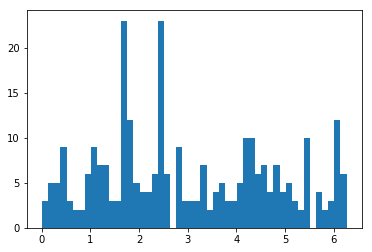

In [58]:
plt.hist(np.mod(seven_frame.iloc[poly][seven_frame.iloc[poly].iloc[:,1]>0.8].iloc[:,3]-seven_frame.iloc[poly][seven_frame.iloc[poly].iloc[:,1]>0.8].iloc[:,4],2*np.pi),bins=50)

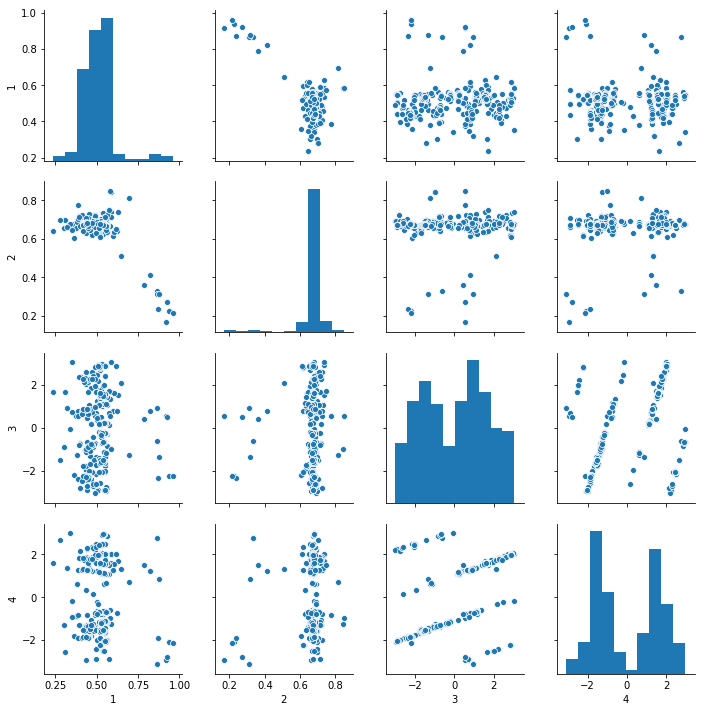

In [37]:
sns.pairplot(seven_frame.iloc[mono][seven_frame.iloc[mono].iloc[:,1:3].apply(np.square).sum(axis=1)<1.2].iloc[:,1:5])

(array([ 15.,  37.,  43.,  18.,  14.,  37.,  16.,  12.,  12.,  11.,   9.,
          8.,   7.,   2.,   7.,   1.,   8.,   9.,   4.,   4.,   4.,   5.,
         10.,   7.,   1.,   0.,   1.,   5.,   3.,   9.,  21.,  27.,  42.,
        150., 118., 205., 183.,  85.,  35.,  16.,  11.,   3.,   0.,   3.,
          0.,   2.,   0.,   1.,   0.,   1.]),
 array([0.00816743, 0.02674604, 0.04532465, 0.06390326, 0.08248187,
        0.10106048, 0.11963909, 0.1382177 , 0.15679631, 0.17537492,
        0.19395353, 0.21253214, 0.23111075, 0.24968936, 0.26826797,
        0.28684658, 0.30542519, 0.3240038 , 0.34258241, 0.36116102,
        0.37973963, 0.39831824, 0.41689685, 0.43547546, 0.45405407,
        0.47263268, 0.49121129, 0.5097899 , 0.52836851, 0.54694712,
        0.56552573, 0.58410434, 0.60268295, 0.62126156, 0.63984017,
        0.65841878, 0.67699739, 0.695576  , 0.71415461, 0.73273322,
        0.75131183, 0.76989044, 0.78846905, 0.80704767, 0.82562628,
        0.84420489, 0.8627835 , 0.88136211, 0.

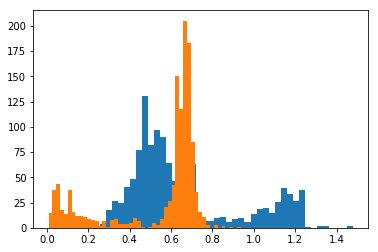

In [20]:
plt.hist(seven_frame.iloc[poly].iloc[:,1],bins=50)
plt.hist(seven_frame.iloc[poly].iloc[:,2],bins=50)

In [23]:
0.7**2+0.5**2

0.74

In [43]:
unconstrained_seven = seven_frame.iloc[alls,:]
stf = unconstrained_seven.iloc[:,19:26].sum(axis=1)==0
filtered_seven = unconstrained_seven[stf]

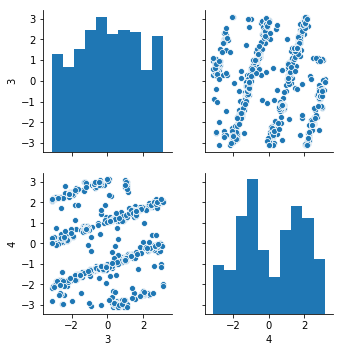

In [38]:
sns.pairplot(seven_frame.iloc[alls,:][seven_frame.iloc[alls,19:25].sum(axis=1)==0].iloc[:,3:5])

In [7]:
a = seven_frame.iloc[alls,:][seven_frame.iloc[alls,19:].values.sum(axis=1)==0]

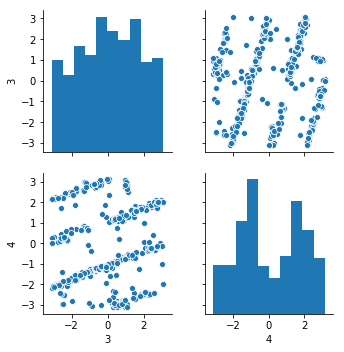

In [8]:
sns.pairplot(a.iloc[:,3:5])

In [9]:
a = seven_frame.iloc[poly]

In [10]:
x = np.arange(-np.pi,np.pi,0.02)
y1 = -np.pi+x/3
y2 = -np.pi/3+x/3
y3 = np.pi/3+x/3
y4 = np.pi+x/3

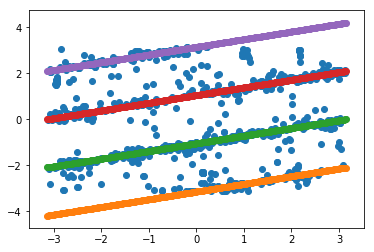

In [11]:
plt.scatter(a.iloc[:,3],a.iloc[:,4])
plt.scatter(x,y1)
plt.scatter(x,y2)
plt.scatter(x,y3)
plt.scatter(x,y4)

In [54]:
a = a.reset_index(drop=True)
t = pd.concat([a.iloc[:,4]-(a.iloc[:,3]/3-np.pi),a.iloc[:,4]-(a.iloc[:,3]/3-np.pi/3),a.iloc[:,4]-(a.iloc[:,3]/3+np.pi/3),a.iloc[:,4]-(a.iloc[:,3]/3+np.pi)],axis=1)
b = a[(np.abs(t)<0.5).apply(any,axis=1)]

In [55]:
notin = [i for i in range(1222) if i not in b.index ]

In [98]:
x1 = np.array([-np.pi/3,np.pi/3])
y1a = 3*x1
y1b = np.pi/3+x1

x2 = np.array([-np.pi/3,0])
y2a = 3*x2
y2b = np.pi+x2

x3 = np.array([-np.pi/3,np.pi/3])
y3a = 3*x1
y3b = -np.pi/3+x1

x4 = np.array([0,np.pi/3])
y4a = 3*x4
y4b = -np.pi+x4



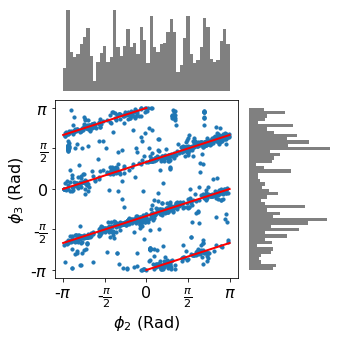

In [101]:
fig = plt.figure(figsize=(5,5))
gs = gridspec.GridSpec(nrows=3, ncols=3, wspace=0.1, hspace=0.1)
x,y, = np.linspace(-np.pi,np.pi,100),np.linspace(-np.pi,np.pi,100)
X,Y  = np.meshgrid(x,y)
ax0_joint = fig.add_subplot(gs[1:3,0:2])
ax0_marg_x = fig.add_subplot(gs[0,0:2])
ax0_marg_y = fig.add_subplot(gs[1:3,2])

ax0_joint.scatter(unconstrained_seven.iloc[:,3],unconstrained_seven.iloc[:,4],s=10)
ax0_joint.plot(y1a,y1b,color="red",lw=2)
ax0_joint.plot(y2a,y2b,color="red",lw=2)
ax0_joint.plot(y3a,y3b,color="red",lw=2)
ax0_joint.plot(y4a,y4b,color="red",lw=2)
ax0_marg_x.hist(unconstrained_seven.iloc[:,3], bins=50, color="grey")
ax0_marg_y.hist(unconstrained_seven.iloc[:,4],orientation="horizontal", bins=50, color="grey")
ax0_marg_x.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_marg_y.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_marg_x.set_axis_off()
ax0_marg_y.set_axis_off()
ax0_joint.set_xlabel(r"$\phi_{2}$ (Rad)", fontsize=16)
ax0_joint.set_ylabel(r"$\phi_{3}$ (Rad)", fontsize=16)
ax0_joint.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_joint.set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_joint.set_xticklabels([r"-$\pi$", r"-$\frac{\pi}{2}$", 0, r"$\frac{\pi}{2}$", r"$\pi$"], fontsize=16)
ax0_joint.set_yticklabels([r"-$\pi$", r"-$\frac{\pi}{2}$", 0, r"$\frac{\pi}{2}$", r"$\pi$"], fontsize=16)
plt.savefig("Fig/Macrocycle/seven_phis_all.pdf",dpi=150, bbox_inches="tight")
plt.show()


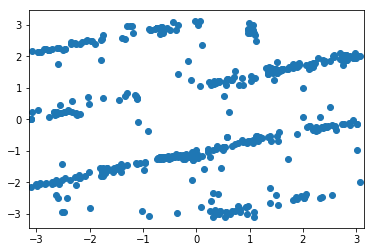

In [524]:
x1 = np.arange(-np.pi,np.pi,0.02)
y1a = np.mod(3*x1,np.pi*2)-np.pi
y1b = np.mod(3*x1+3*np.pi/7,np.pi*2)-np.pi
y2a = np.mod(x1+np.pi,np.pi*2)-np.pi
y2b = np.mod(x1+np.pi+np.pi/7,np.pi*2)-np.pi
#plt.scatter(y1a,y2a)
plt.xlim(-np.pi,np.pi)
plt.scatter(b.iloc[:,3],b.iloc[:,4])
plt.show()
#plt.scatter(b.iloc[:,3],b.iloc[:,4])

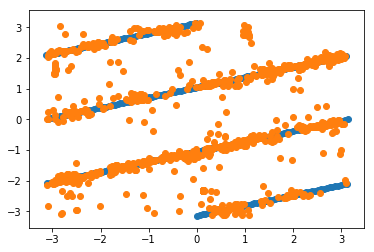

In [267]:
x1 = np.arange(-np.pi,np.pi,0.02)
y1a = np.mod(3*x1,np.pi*2)-np.pi
y1b = np.mod(3*x1+3*np.pi/7,np.pi*2)-np.pi
y2a = np.mod(x1+np.pi,np.pi*2)-np.pi
y2b = np.mod(x1+np.pi+np.pi/7,np.pi*2)-np.pi
plt.scatter(y1a,y2a)
#plt.scatter(y1b,y2b)
plt.scatter(b.iloc[:,3],b.iloc[:,4])
#plt.scatter(y2a,y2b)

# Eight-membered Ring

In [102]:
eight = Chem.SDMolSupplier("eight_all.sdf")

In [103]:
result = []
smarts_1 = Chem.MolFromSmarts("[C;R](=O)[O,N;R]") 
smarts_2 = Chem.MolFromSmarts("[Si;R][O;R]")
for idx, mol in enumerate(eight):
    bonds = []
    mat1 = mol.GetSubstructMatches(smarts_1)
    mat2 = mol.GetSubstructMatches(smarts_2)
    mat3 = mol.GetSubstructMatches(smarts_3)
    mat4 = mol.GetSubstructMatches(smarts_4)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==8:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                ringatom = [item[1] for item in RA.GetRingElement(mol, ringloop)]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                check1 = [set(ringloop).intersection(set(mat)) for mat in mat1]
                check2 = [set(ringloop).intersection(set(mat)) for mat in mat2]
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype, *ringatom, any(check1),any(check2)))


In [104]:
eight_frame = pd.DataFrame(result)
mono = []
poly = []
for idx in range(1007):
    check1 = [x==1.0 for x in eight_frame.iloc[idx,6:14].values]
    check2 = [x=="M" for x in eight_frame.iloc[idx,14:22].values]
    if all(check1) and all(check2):
        mono.append(idx)
    elif all(check1) and not all(check2):
        poly.append(idx)
    else:
        continue

In [105]:
alls = mono+poly

In [114]:
sel = eight_frame.iloc[alls,:][eight_frame.iloc[alls,30:32].values.sum(axis=1)==0]

In [115]:
x1 = np.array([-np.pi/2,np.pi/2])
y1a = 2*x1
y1b = np.pi/2+x1

x2 = np.array([-np.pi/2,0])
y2a = 2*x2
y2b = np.pi+x2

x3 = np.array([-np.pi/2,np.pi/2])
y3a = 2*x1
y3b = -np.pi/2+x1

x4 = np.array([-np.pi/2,np.pi/2])
y4a = 2*x4
y4b = x4

x5 = np.array([0,np.pi/2])
y5a = 2*x5
y5b = -np.pi+x5

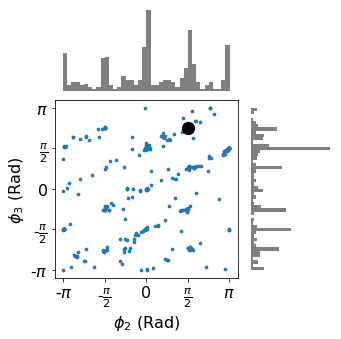

In [119]:
fig = plt.figure(figsize=(5,5))
gs = gridspec.GridSpec(nrows=3, ncols=3, wspace=0.1, hspace=0.1)
x,y, = np.linspace(-np.pi,np.pi,100),np.linspace(-np.pi,np.pi,100)
X,Y  = np.meshgrid(x,y)
ax0_joint = fig.add_subplot(gs[1:3,0:2])
ax0_marg_x = fig.add_subplot(gs[0,0:2])
ax0_marg_y = fig.add_subplot(gs[1:3,2])

ax0_joint.scatter(sel.iloc[:,4],sel.iloc[:,5],s=7)
#ax0_joint.plot(y1a,y1b,lw=2, color="red")
#ax0_joint.plot(y2a,y2b,lw=2, color="red")
#ax0_joint.plot(y3a,y3b,lw=2, color="red")
#ax0_joint.plot(y4a,y4b,lw=2, color="red")
#ax0_joint.plot(y5a,y5b,lw=2, color="red")
ax0_joint.scatter(sel.iloc[30,4],sel.iloc[30,5], color="black", s=150)
ax0_marg_x.hist(sel.iloc[:,4], bins=40, color="grey")
ax0_marg_y.hist(sel.iloc[:,5],orientation="horizontal", bins=50, color="grey")
ax0_marg_x.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_marg_y.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_marg_x.set_axis_off()
ax0_marg_y.set_axis_off()
ax0_joint.set_xlabel(r"$\phi_{2}$ (Rad)", fontsize=16)
ax0_joint.set_ylabel(r"$\phi_{3}$ (Rad)", fontsize=16)
ax0_joint.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_joint.set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_joint.set_xticklabels([r"-$\pi$", r"-$\frac{\pi}{2}$", 0, r"$\frac{\pi}{2}$", r"$\pi$"], fontsize=16)
ax0_joint.set_yticklabels([r"-$\pi$", r"-$\frac{\pi}{2}$", 0, r"$\frac{\pi}{2}$", r"$\pi$"], fontsize=16)
#plt.savefig("Fig/Macrocycle/eight_phis.pdf",dpi=150, bbox_inches="tight")
plt.show()

(array([13.,  4.,  3.,  2.,  3.,  3.,  8., 17., 12., 12.,  5.,  2.,  3.,
         5., 52., 61.,  6.,  8.,  3.,  7.,  7.,  6., 43., 11.,  4.,  2.,
         2.,  1.,  8.,  8.]),
 array([1.24950397e-04, 1.04439034e-01, 2.08753118e-01, 3.13067201e-01,
        4.17381285e-01, 5.21695369e-01, 6.26009452e-01, 7.30323536e-01,
        8.34637620e-01, 9.38951703e-01, 1.04326579e+00, 1.14757987e+00,
        1.25189395e+00, 1.35620804e+00, 1.46052212e+00, 1.56483621e+00,
        1.66915029e+00, 1.77346437e+00, 1.87777846e+00, 1.98209254e+00,
        2.08640662e+00, 2.19072071e+00, 2.29503479e+00, 2.39934887e+00,
        2.50366296e+00, 2.60797704e+00, 2.71229113e+00, 2.81660521e+00,
        2.92091929e+00, 3.02523338e+00, 3.12954746e+00]),
 <a list of 30 Patch objects>)

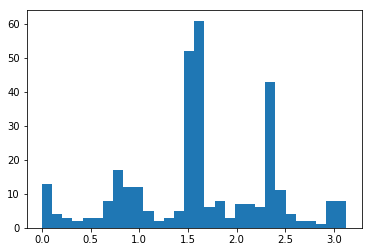

In [123]:
plt.hist(np.mod(sel.iloc[:,4]-sel.iloc[:,5],np.pi),bins=30)

In [134]:
x = np.arange(-np.pi,np.pi,0.05)
y = x+np.random.uniform(-0.01,0.01)

In [136]:

sel.iloc[30,4],sel.iloc[30,5]


(1.5894701365441688, 2.3562830576963867)

0.7480282325319081

In [8]:
len(alls)

455

In [9]:
len(sel)

317

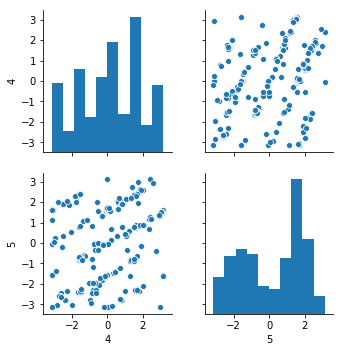

In [58]:
sns.pairplot(sel.iloc[:,4:6])

In [59]:
x = np.arange(-np.pi,np.pi,0.02)
y1 = -np.pi/2+x/2
y2 = x/2
y3 = np.pi+x/2
y4 = np.pi/2+x/2
y5 = -np.pi+x/2

In [60]:
sel = sel.reset_index(drop=True)
t1 = pd.concat([sel.iloc[:,4]-(sel.iloc[:,3]/2-np.pi/2),
                sel.iloc[:,4]-(sel.iloc[:,3]/2-np.pi),
                sel.iloc[:,4]-(sel.iloc[:,3]/2+np.pi/2),
                sel.iloc[:,4]-(sel.iloc[:,3]/2+np.pi),
               sel.iloc[:,4]-(sel.iloc[:,3]/2)],axis=1)

In [89]:
b = sel[(np.abs(t1)<0.7).apply(any,axis=1)]

In [90]:
len(b)

303

In [91]:
len(alls)

455

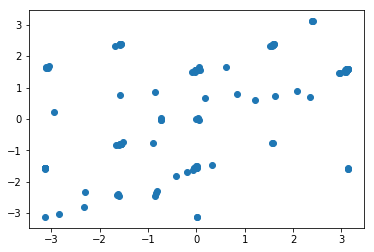

In [120]:
plt.scatter(sel.iloc[:,4],sel.iloc[:,5])
# plt.scatter(x,y1)
# plt.scatter(x,y2)
# plt.scatter(x,y3)
# plt.scatter(x,y4)
# plt.scatter(x,y5)
plt.show()

In [119]:
b[(b.iloc[:,4]<0.5) & (b.iloc[:,4]>-0)  & (b.iloc[:,5]>-0.5)  & (b.iloc[:,5]<)]

SyntaxError: invalid syntax (<ipython-input-119-c27b21ddcccb>, line 1)

(array([10.,  2.,  0.,  2.,  1.,  8.,  9., 12.,  3.,  2.,  2., 11., 41.,
         3.,  4.,  4.,  3.,  4., 16.,  4.,  0.,  0.,  0.,  2.,  3.,  3.,
         2.,  1.,  2.,  2.,  3., 13.,  2.,  1.,  0.,  0.,  4., 45., 16.,
         4.,  0.,  2.,  1., 25., 12.,  4.,  2.,  1.,  7.,  5.]),
 array([1.24950397e-04, 1.25545254e-01, 2.50965557e-01, 3.76385860e-01,
        5.01806163e-01, 6.27226467e-01, 7.52646770e-01, 8.78067073e-01,
        1.00348738e+00, 1.12890768e+00, 1.25432798e+00, 1.37974829e+00,
        1.50516859e+00, 1.63058889e+00, 1.75600920e+00, 1.88142950e+00,
        2.00684980e+00, 2.13227011e+00, 2.25769041e+00, 2.38311071e+00,
        2.50853102e+00, 2.63395132e+00, 2.75937162e+00, 2.88479193e+00,
        3.01021223e+00, 3.13563253e+00, 3.26105284e+00, 3.38647314e+00,
        3.51189344e+00, 3.63731374e+00, 3.76273405e+00, 3.88815435e+00,
        4.01357465e+00, 4.13899496e+00, 4.26441526e+00, 4.38983556e+00,
        4.51525587e+00, 4.64067617e+00, 4.76609647e+00, 4.89151678e+

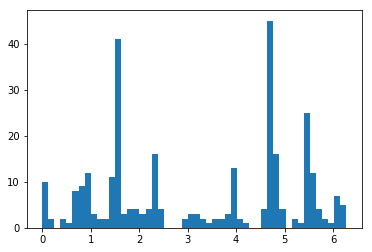

In [99]:
plt.hist(np.mod(b.iloc[:,4]-b.iloc[:,5],2*np.pi),bins=50)

In [494]:
b.index

Int64Index([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            306, 307, 308, 309, 310, 311, 313, 314, 315, 316],
           dtype='int64', length=292)

In [495]:
notin = [x for x in range(317) if x not in b.index]

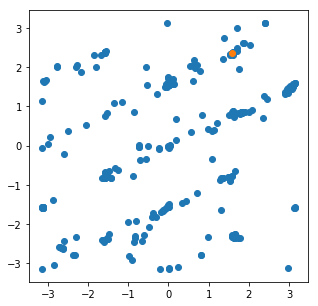

In [104]:
fig = plt.figure(figsize=(5,5))
plt.scatter(b.iloc[:,4],b.iloc[:,5])
plt.scatter(sel.iloc[30,4],sel.iloc[30,5])

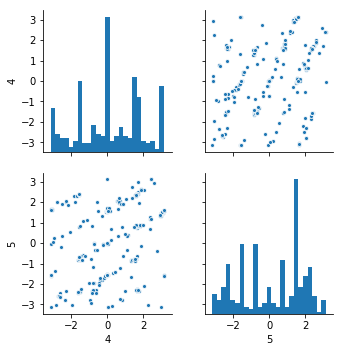

In [120]:
sns.pairplot(sele[sele.iloc[:,30:].values.sum(axis=1)==0].iloc[:,4:6],plot_kws=dict(s=15),diag_kws=dict(bins=25))

In [88]:
mono_8 = mono_eight[mono_eight.iloc[:,30:].values.sum(axis=1)==0]
poly_8 = poly_eight[poly_eight.iloc[:,30:].values.sum(axis=1)==0]

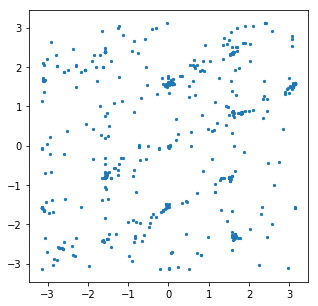

In [116]:
plt.figure(figsize=(5,5))
plt.scatter(sele.iloc[:,4],sele.iloc[:,5],s=5)
#plt.scatter(mono_8.iloc[:,4],mono_8.iloc[:,5])
#plt.scatter(poly_8.iloc[:,4],poly_8.iloc[:,5])

In [74]:
nine = Chem.SDMolSupplier("nine.sdf",removeHs=False)

In [101]:
result = []
smarts = Chem.MolFromSmarts("[C;R](=O)[N,O;R]")
for idx, mol in enumerate(nine):
    bonds = []
    matches = mol.GetSubstructMatches(smarts)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==9:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                torsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%9,(i+1)%9,(i+2)%9,(i+3)%9]]) for i in range(9) ]
                check = [(mat[0] in ringloop) and (mat[2] in ringloop) for mat in matches]
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*torsion, any(check)))

In [111]:
c = []
for idx, item in enumerate(pd.DataFrame(result).iloc[:,7:16].values):
    check = [x!=1 for x in item]
    c.append(sum(check))

In [123]:
dataframe = pd.DataFrame(result)
keep  = dataframe[[item==0 for item in c] & (dataframe.iloc[:,-1]==False)]

(array([ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  3.,  0.,  0.,  0.,
         0.,  2.,  5.,  1.,  1.,  3.,  3.,  8., 10.,  7., 10., 12.,  5.,
         3.,  0.,  0.,  0.,  0.,  1.,  3.,  1.,  5.,  3.,  4.,  4.,  2.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([1.21736123, 1.25061386, 1.28386648, 1.31711911, 1.35037173,
        1.38362436, 1.41687698, 1.45012961, 1.48338223, 1.51663486,
        1.54988748, 1.58314011, 1.61639273, 1.64964536, 1.68289798,
        1.71615061, 1.74940323, 1.78265586, 1.81590848, 1.84916111,
        1.88241373, 1.91566636, 1.94891898, 1.98217161, 2.01542423,
        2.04867686, 2.08192948, 2.11518211, 2.14843473, 2.18168736,
        2.21493998, 2.24819261, 2.28144523, 2.31469786, 2.34795048,
        2.38120311, 2.41445573, 2.44770836, 2.48096098, 2.51421361,
        2.54746623, 2.58071886, 2.61397148, 2.64722411, 2.68047673,
        2.71372936, 2.74698198, 2.78023461, 2.81348723, 2.84673986,
        2.87999248]),
 <a list of 50

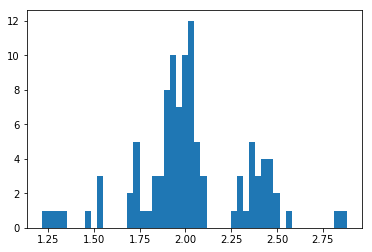

In [129]:
plt.hist(keep.iloc[:,1:4].sum(axis=1),bins=50)

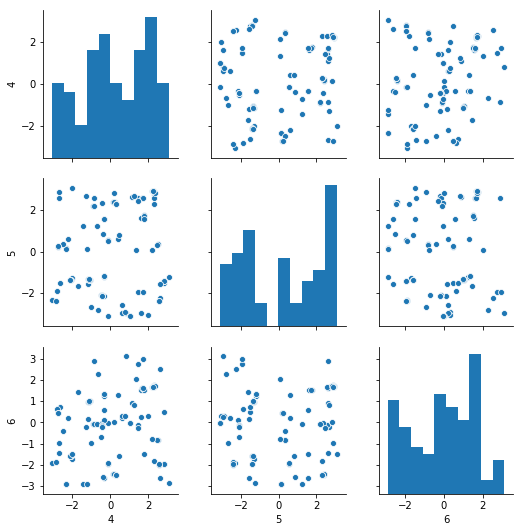

In [124]:
sns.pairplot(keep.iloc[:,4:7])

# Twelve

In [264]:
nine = Chem.SDMolSupplier("../Extra/extra.sdf",removeHs=False)

In [226]:
result = []
smarts = Chem.MolFromSmarts("[C;R](=O)[O,N;R]")
for idx, mol in enumerate(nine):
    bonds = []
    matches = mol.GetSubstructMatches(smarts)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    size = []
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            size.append(len(rc.nodes))
    result.append(max(size))
            

# Fifteen

In [130]:
crownether = Chem.SDMolSupplier("conformers.sdf")

In [131]:
result = []
for idx, mol in enumerate(crownether):
    bonds = []
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==15:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                torsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%15,(i+1)%15,(i+2)%15,(i+3)%15]]) for i in range(15) ]
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*torsion))

In [132]:
dataframe = pd.DataFrame(result).iloc[:,1:13]

In [133]:
coss = np.cos(dataframe.iloc[:,6:13])
sins = np.sin(dataframe.iloc[:,6:13])

In [141]:
a1= pd.concat([coss,sins],axis=1)
a1.columns= list(range(12))

(array([2., 0., 3., 1., 4., 6., 3., 0., 0., 1.]),
 array([-1.49987102, -1.16265076, -0.8254305 , -0.48821024, -0.15098998,
         0.18623028,  0.52345054,  0.8606708 ,  1.19789106,  1.53511132,
         1.87233158]),
 <a list of 10 Patch objects>)

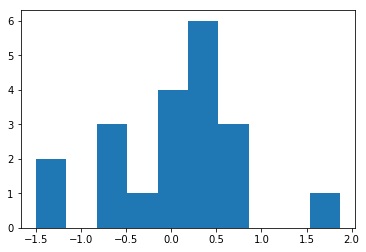

In [151]:
plt.hist(a1.iloc[:20,-3]+a1.iloc[:20,-2])

In [152]:
from sklearn.cross_decomposition import CCA

In [170]:
cca = CCA(n_components=2)

In [171]:
cca.fit(X, Y)

/home/lucian/anaconda3/envs/Chem/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:291: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


CCA(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

In [172]:
X_c, Y_c = cca.transform(X, Y)

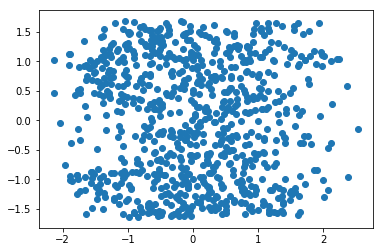

In [176]:
plt.scatter(pd.DataFrame(X_c).iloc[:,0],Y_c)

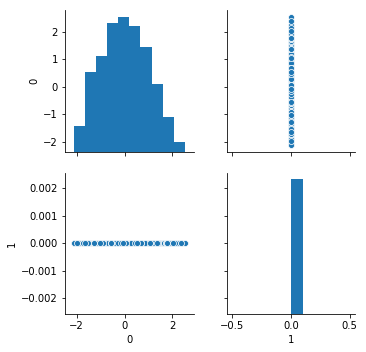

In [173]:
sns.pairplot(pd.DataFrame(X_c))

In [154]:
X=dataframe.iloc[:,-4:-1]
Y=dataframe.iloc[:,-1]

In [53]:
sq = dataframe.iloc[:,0:6].apply(np.square).sum(axis=1).apply(np.sqrt)

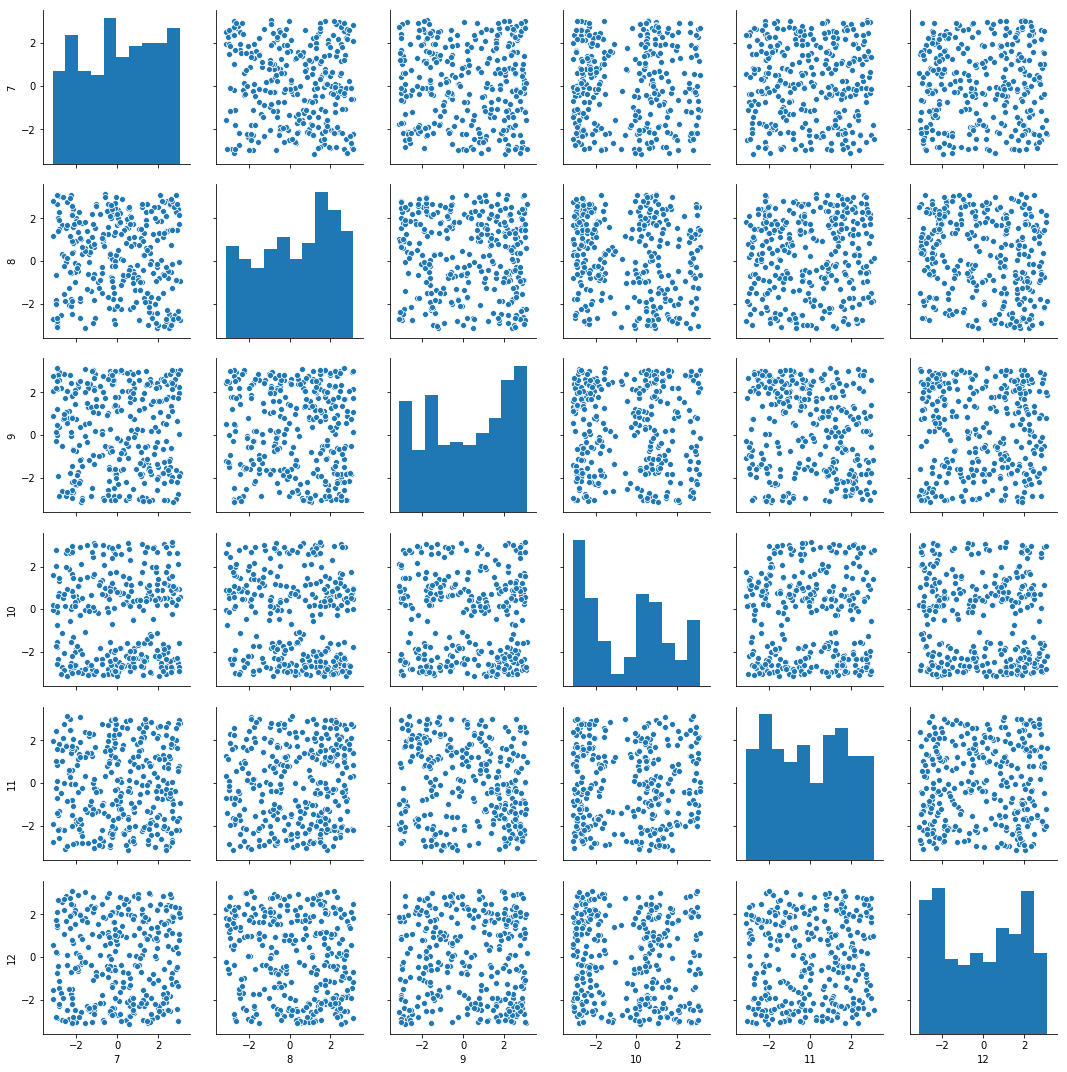

In [64]:
sns.pairplot(dataframe[(sq>2)&(sq<2.5)].iloc[:,6:13])

(array([ 8., 12.,  4.,  8.,  4.,  8.,  6.,  5.,  9.,  6.,  5.,  8.,  7.,
        12.,  6.,  6., 15.,  8.,  6.,  8., 10.,  0.,  4.,  7.,  7.,  5.,
         9.,  5.,  7.,  6.,  3.,  7.,  7.,  6.,  7.,  3.,  7.,  4.,  7.,
         4.,  3.,  7.,  6.,  5.,  5.,  2., 11.,  4.,  6.,  8.]),
 array([0.00979695, 0.13508506, 0.26037316, 0.38566127, 0.51094938,
        0.63623749, 0.7615256 , 0.88681371, 1.01210182, 1.13738992,
        1.26267803, 1.38796614, 1.51325425, 1.63854236, 1.76383047,
        1.88911857, 2.01440668, 2.13969479, 2.2649829 , 2.39027101,
        2.51555912, 2.64084723, 2.76613533, 2.89142344, 3.01671155,
        3.14199966, 3.26728777, 3.39257588, 3.51786399, 3.64315209,
        3.7684402 , 3.89372831, 4.01901642, 4.14430453, 4.26959264,
        4.39488074, 4.52016885, 4.64545696, 4.77074507, 4.89603318,
        5.02132129, 5.1466094 , 5.2718975 , 5.39718561, 5.52247372,
        5.64776183, 5.77304994, 5.89833805, 6.02362615, 6.14891426,
        6.27420237]),
 <a list of 50

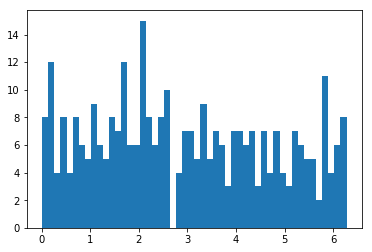

In [68]:
plt.hist(np.mod(dataframe[(sq>2)&(sq<2.5)].iloc[:,10]-dataframe[(sq>2)&(sq<2.5)].iloc[:,11],2*np.pi),bins=50)

In [41]:
a1 = pd.concat([coss,sins],axis=1)
a1.columns=list(range(12))

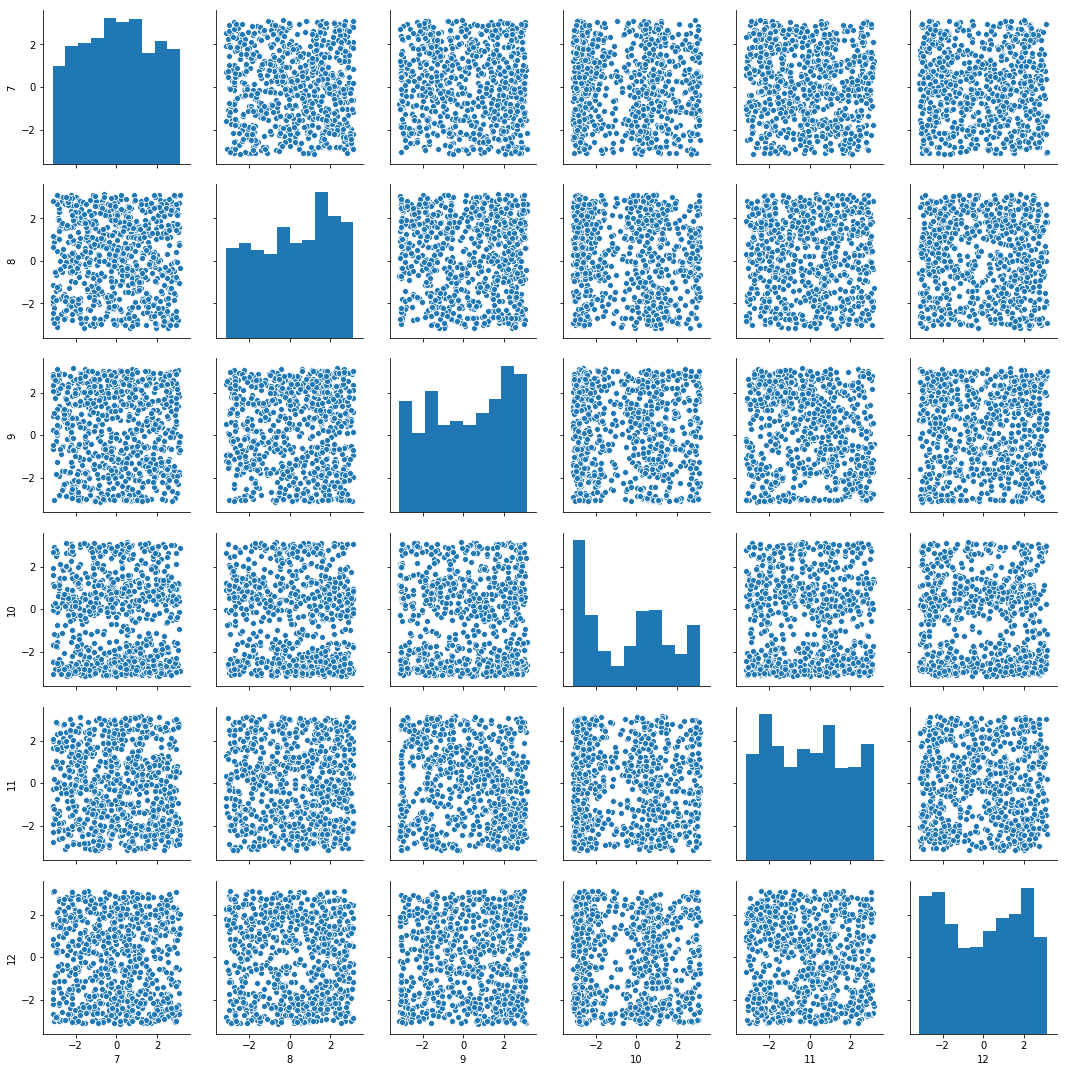

In [73]:
sns.pairplot(dataframe.iloc[:800,6:13])

In [ ]:
result = []
smarts = Chem.MolFromSmarts("[C;R](=O)[O,N;R][H]")
for idx, mol in enumerate(nine):
    bonds = []
    matches = mol.GetSubstructMatches(smarts)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==12:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                check = [(mat[0] in ringloop) & (mat[2] in ringloop) for mat in matches]
                cistrans = []
                for item in matches:
                    if (item[0] in ringloop) and (item[2] in ringloop):
                        t = rdMolTransforms.GetDihedralRad(mol.GetConformer(), item[1],item[0],item[2],item[3])
                        if np.abs(t)<np.pi/6:
                            cistrans.append("C")
                        elif np.abs(t)>np.pi*5/6:
                            cistrans.append("T")
                        else:
                            print(idx)
                torsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%12,(i+1)%12,(i+2)%12,(i+3)%12]]) for i in range(12) ]
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*torsion, sum(check), *cistrans))

In [482]:
tw = pd.DataFrame(result)

In [ ]:
tw.iloc[:,]

In [551]:
cc =tw[(tw.iloc[:,47]=="C") & (tw.iloc[:,48]=="C")].iloc[:,1:10]
ct =tw[(tw.iloc[:,47]=="C") & (tw.iloc[:,48]=="T")].iloc[:,1:10]
tc =tw[(tw.iloc[:,47]=="T") & (tw.iloc[:,48]=="C")].iloc[:,1:10]

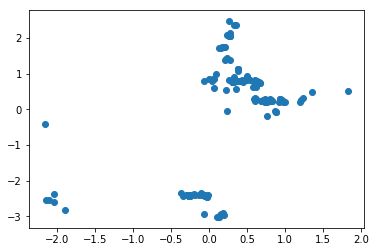

In [521]:
plt.scatter(.3*cc.iloc[:,0]+.5*cc.iloc[:,1], cc.iloc[:,2])

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

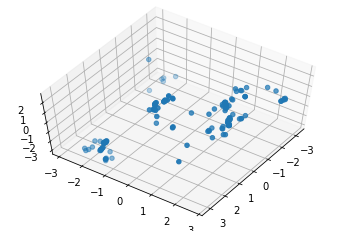

In [524]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(60, 35)
ax.scatter3D(cc.iloc[:,0], cc.iloc[:,1], cc.iloc[:,2], 'gray')


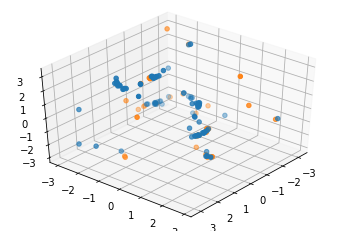

In [533]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(40, 40)
ax.scatter3D(tc.iloc[:,0], tc.iloc[:,1], tc.iloc[:,2], 'gray')
ax.scatter3D(ct.iloc[:,0], ct.iloc[:,1], ct.iloc[:,2], 'gray')

In [565]:
a1,a2 = cc.iloc[:,0]*np.cos(cc.iloc[:,5]), cc.iloc[:,0]*np.sin(cc.iloc[:,5])
a3,a4 = cc.iloc[:,1]*np.cos(cc.iloc[:,6]), cc.iloc[:,1]*np.sin(cc.iloc[:,6])
a5,a6 = cc.iloc[:,2]*np.cos(cc.iloc[:,7]), cc.iloc[:,2]*np.sin(cc.iloc[:,7])
a7,a8 = cc.iloc[:,3]*np.cos(cc.iloc[:,8]), cc.iloc[:,3]*np.sin(cc.iloc[:,8])
a = pd.concat([a1,a2,a3,a4,a5,a6,a7,a8],axis=1)

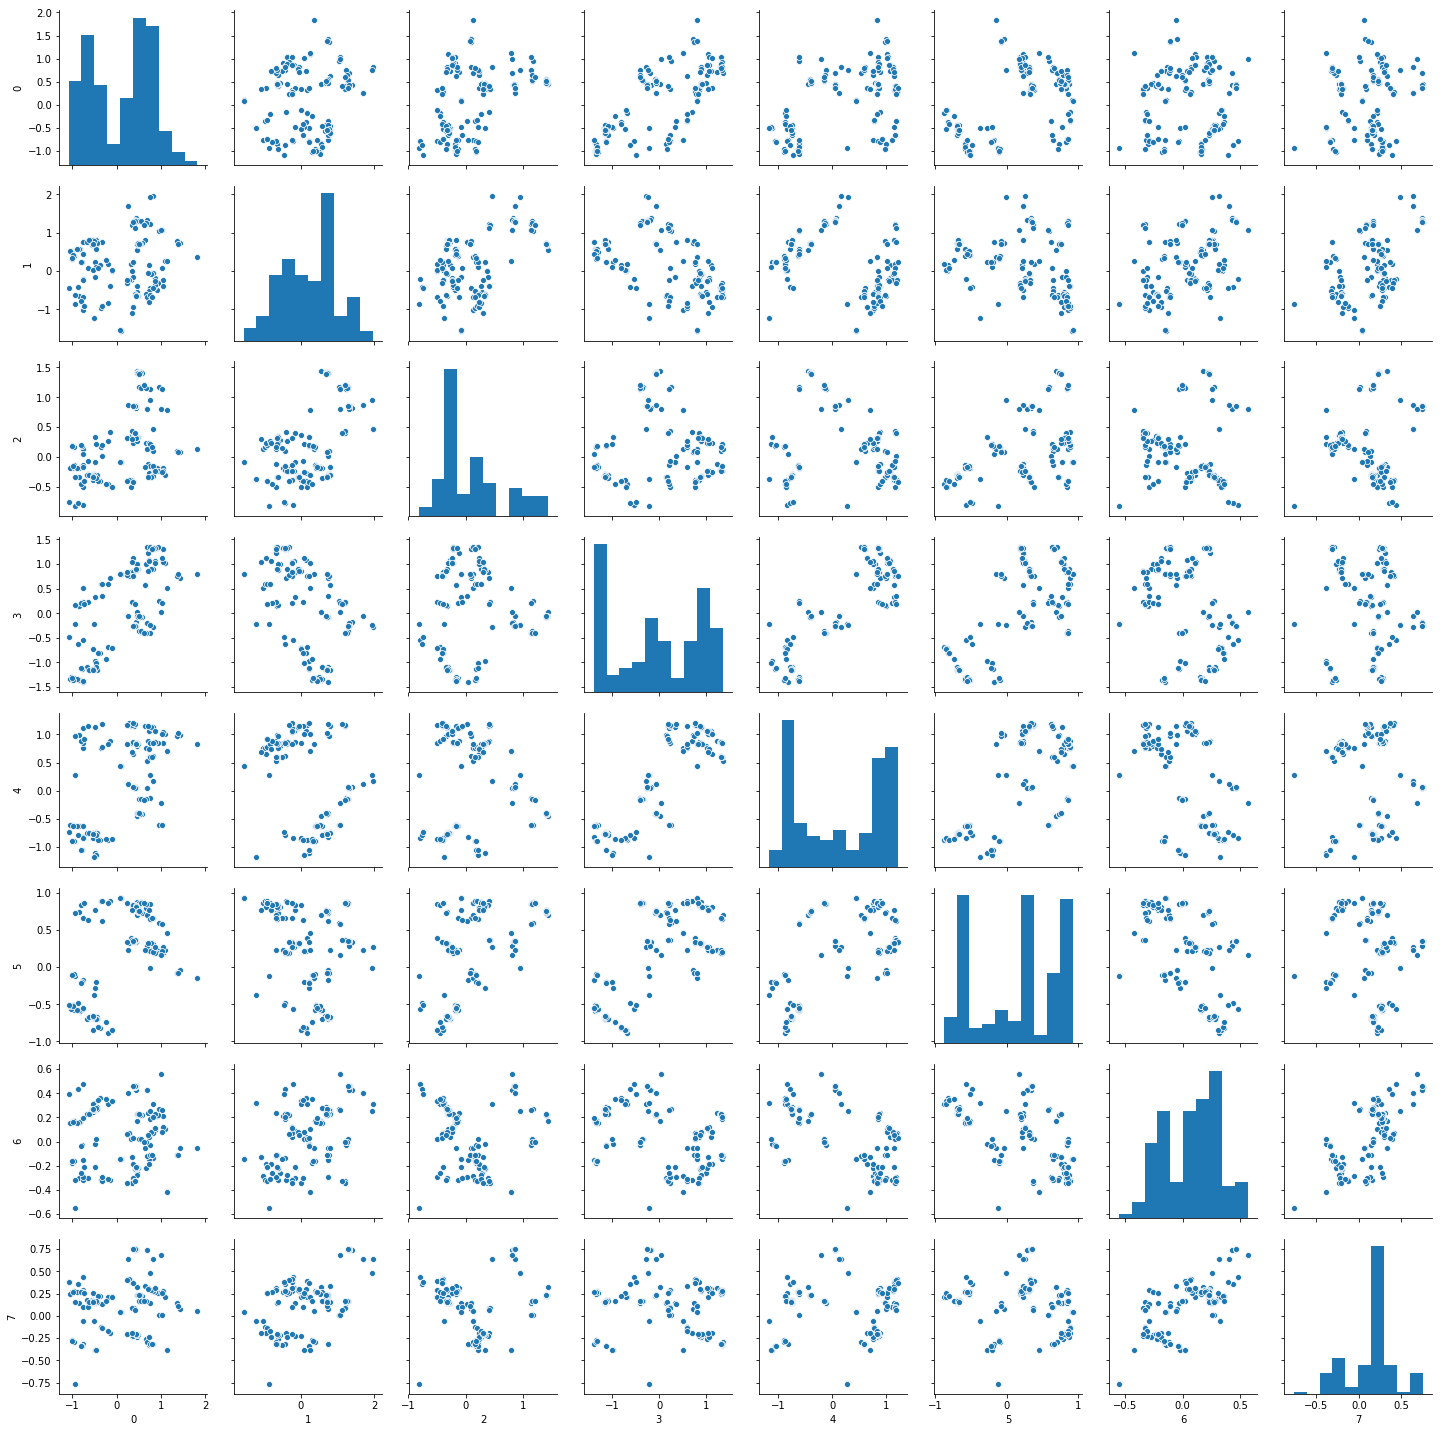

In [566]:
sns.pairplot(a)

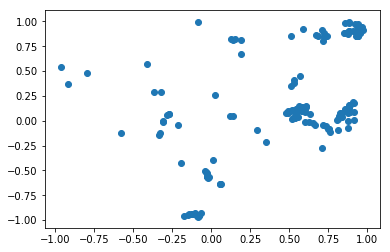

In [549]:
plt.scatter(np.cos(cc.iloc[:,0])*np.sin(cc.iloc[:,1]),np.cos(2*cc.iloc[:,2]))

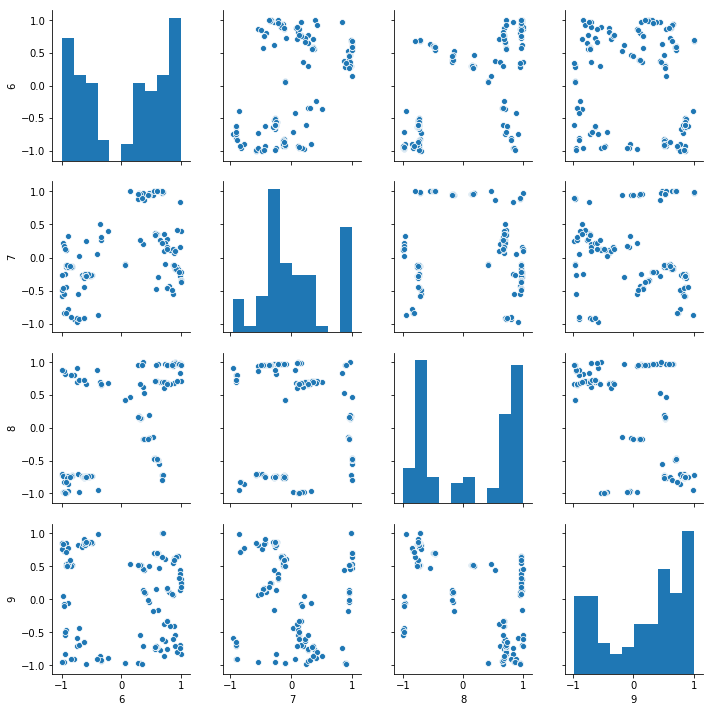

In [540]:
sns.pairplot(cc.apply(np.cos))

In [483]:
c1 = []
c2 = []
c3 = []
c4 = []
c5 = []
c6 = []
for idx, item in enumerate(tw[tw.iloc[:,62]==4].iloc[:,63:].values):
    if list(item)==["T","T","T","T"]:
        c1.append(idx)
    elif list(item)==["C","C","C","T"] or list(item)==["C","C","T","C"] or list(item)==["C","T","C","C"] or list(item)==["T","C","C","C"]:
        c2.append(idx)
    elif list(item)==["C","T","C","T"] or list(item)==["T","C","T","C"]:
        c3.append(idx)
    elif list(item)==["C","C","T","T"] or list(item)==["C","T","T","C"] or list(item)==["T","T","C","C"] or list(item)==["T","C","C","T"]:
        c4.append(idx)
    elif list(item)==["C","C","C","C"]:
        c5.append(idx)
    else:
        c6.append(idx)

IndexError: single positional indexer is out-of-bounds

In [397]:
print(len(c1),len(c2),len(c3),len(c4),len(c5),len(c6))

43 226 84 142 58 182


/home/lucian/anaconda3/envs/Chem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


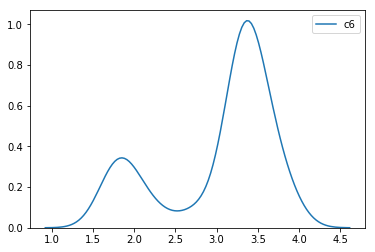

In [425]:
#sns.kdeplot(sixteen.iloc[c1,1:8].apply(np.square).sum(axis=1).apply(np.sqrt),label="c1")
#sns.kdeplot(sixteen.iloc[c2,1:8].apply(np.square).sum(axis=1).apply(np.sqrt),label="c2")
#sns.kdeplot(sixteen.iloc[c3,1:8].apply(np.square).sum(axis=1).apply(np.sqrt),label="c3")
#sns.kdeplot(sixteen.iloc[c4,1:8].apply(np.square).sum(axis=1).apply(np.sqrt),label="c4")
#sns.kdeplot(sixteen.iloc[c5,1:8].apply(np.square).sum(axis=1).apply(np.sqrt),label="c5")
sns.kdeplot(sixteen.iloc[c6,1:8].apply(np.square).sum(axis=1).apply(np.sqrt),label="c6")

(array([ 2.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  3.,  3.,  2.,  1.,  4.,
         1.,  5.,  0.,  1.,  4.,  8.,  5.,  3., 25., 28., 43.,  9., 12.,
         6.,  8.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([0.11550839, 0.23324304, 0.35097769, 0.46871233, 0.58644698,
        0.70418162, 0.82191627, 0.93965092, 1.05738556, 1.17512021,
        1.29285485, 1.4105895 , 1.52832415, 1.64605879, 1.76379344,
        1.88152809, 1.99926273, 2.11699738, 2.23473202, 2.35246667,
        2.47020132, 2.58793596, 2.70567061, 2.82340525, 2.9411399 ,
        3.05887455, 3.17660919, 3.29434384, 3.41207848, 3.52981313,
        3.64754778, 3.76528242, 3.88301707, 4.00075172, 4.11848636,
        4.23622101, 4.35395565, 4.4716903 , 4.58942495, 4.70715959,
        4.82489424, 4.94262888, 5.06036353, 5.17809818, 5.29583282,
        5.41356747, 5.53130211, 5.64903676, 5.76677141, 5.88450605,
        6.0022407 ]),
 <a list of 50

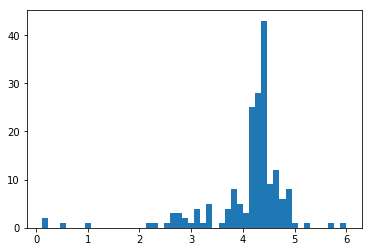

In [437]:
plt.hist(np.mod(sixteen.iloc[c6,8]+sixteen.iloc[c6,9],2*np.pi),bins=50)

In [462]:
mols = Chem.SDMolSupplier("../Extra/JHUQBKYRSKYAPF-NAKRPEOUSA-N-conformers.sdf")

In [463]:
result = []
smarts = Chem.MolFromSmarts("[C;R](=O)[O,N;R][H]")
for idx, mol in enumerate(mols):
    bonds = []
    matches = mol.GetSubstructMatches(smarts)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==16:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                check = [(mat[0] in ringloop) & (mat[2] in ringloop) for mat in matches]
                cistrans = []
                for item in matches:
                    if (item[0] in ringloop) and (item[2] in ringloop):
                        t = rdMolTransforms.GetDihedralRad(mol.GetConformer(), item[1],item[0],item[2],item[3])
                        if np.abs(t)<np.pi/6:
                            cistrans.append("C")
                        elif np.abs(t)>np.pi*5/6:
                            cistrans.append("T")
                        else:
                            print(idx)
                torsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%16,(i+1)%16,(i+2)%16,(i+3)%16]]) for i in range(16) ]
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*torsion, sum(check), *cistrans))

In [363]:
c1 = []
c2 = []
c3 = []
c4 = []
c5 = []
c6 = []
for idx, item in enumerate(thirteen[thirteen.iloc[:,55]==4].iloc[:,56:].values):
    if list(item)==["T","T","T","T"]:
        c1.append(idx)
    elif list(item)==["C","C","C","T"] or list(item)==["C","C","T","C"] or list(item)==["C","T","C","C"] or list(item)==["T","C","C","C"]:
        c2.append(idx)
    elif list(item)==["C","T","C","T"] or list(item)==["T","C","T","C"]:
        c3.append(idx)
    elif list(item)==["C","C","T","T"] or list(item)==["C","T","T","C"] or list(item)==["T","T","C","C"] or list(item)==["T","C","C","T"]:
        c4.append(idx)
    elif list(item)==["C","C","C","C"]:
        c5.append(idx)
    else:
        c6.append(idx)

In [370]:
len(c6)

182

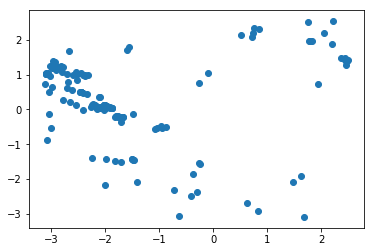

In [375]:
plt.scatter(thirteen[thirteen.iloc[:,55]==4].iloc[c6,8],thirteen[thirteen.iloc[:,55]==4].iloc[c6,9])
#plt.scatter(thirteen[thirteen.iloc[:,55]==4].iloc[c1,8],thirteen[thirteen.iloc[:,55]==4].iloc[c1,10])

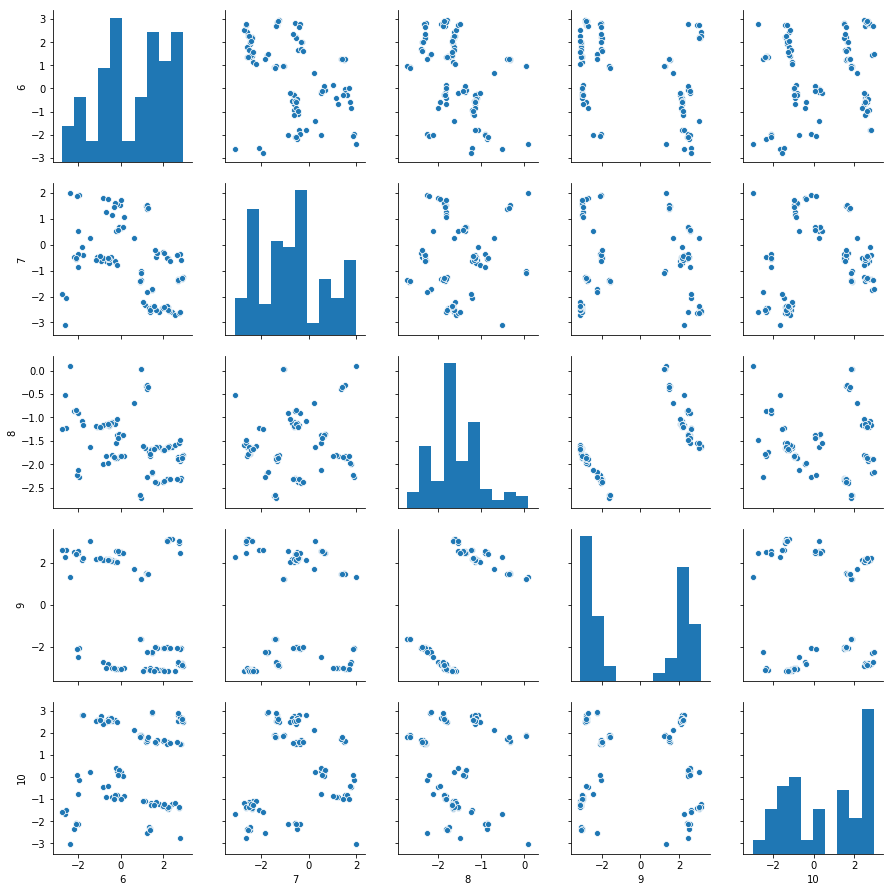

In [327]:
sns.pairplot(thirteen[thirteen.iloc[:,46]==4].iloc[c5,6:11])

In [247]:
np.unique(thirteen.iloc[:,11:24].sum(axis=1))

array([13.])

In [252]:
np.unique(thirteen.iloc[:,46],return_counts=True)

(array([3, 4]), array([656, 742]))

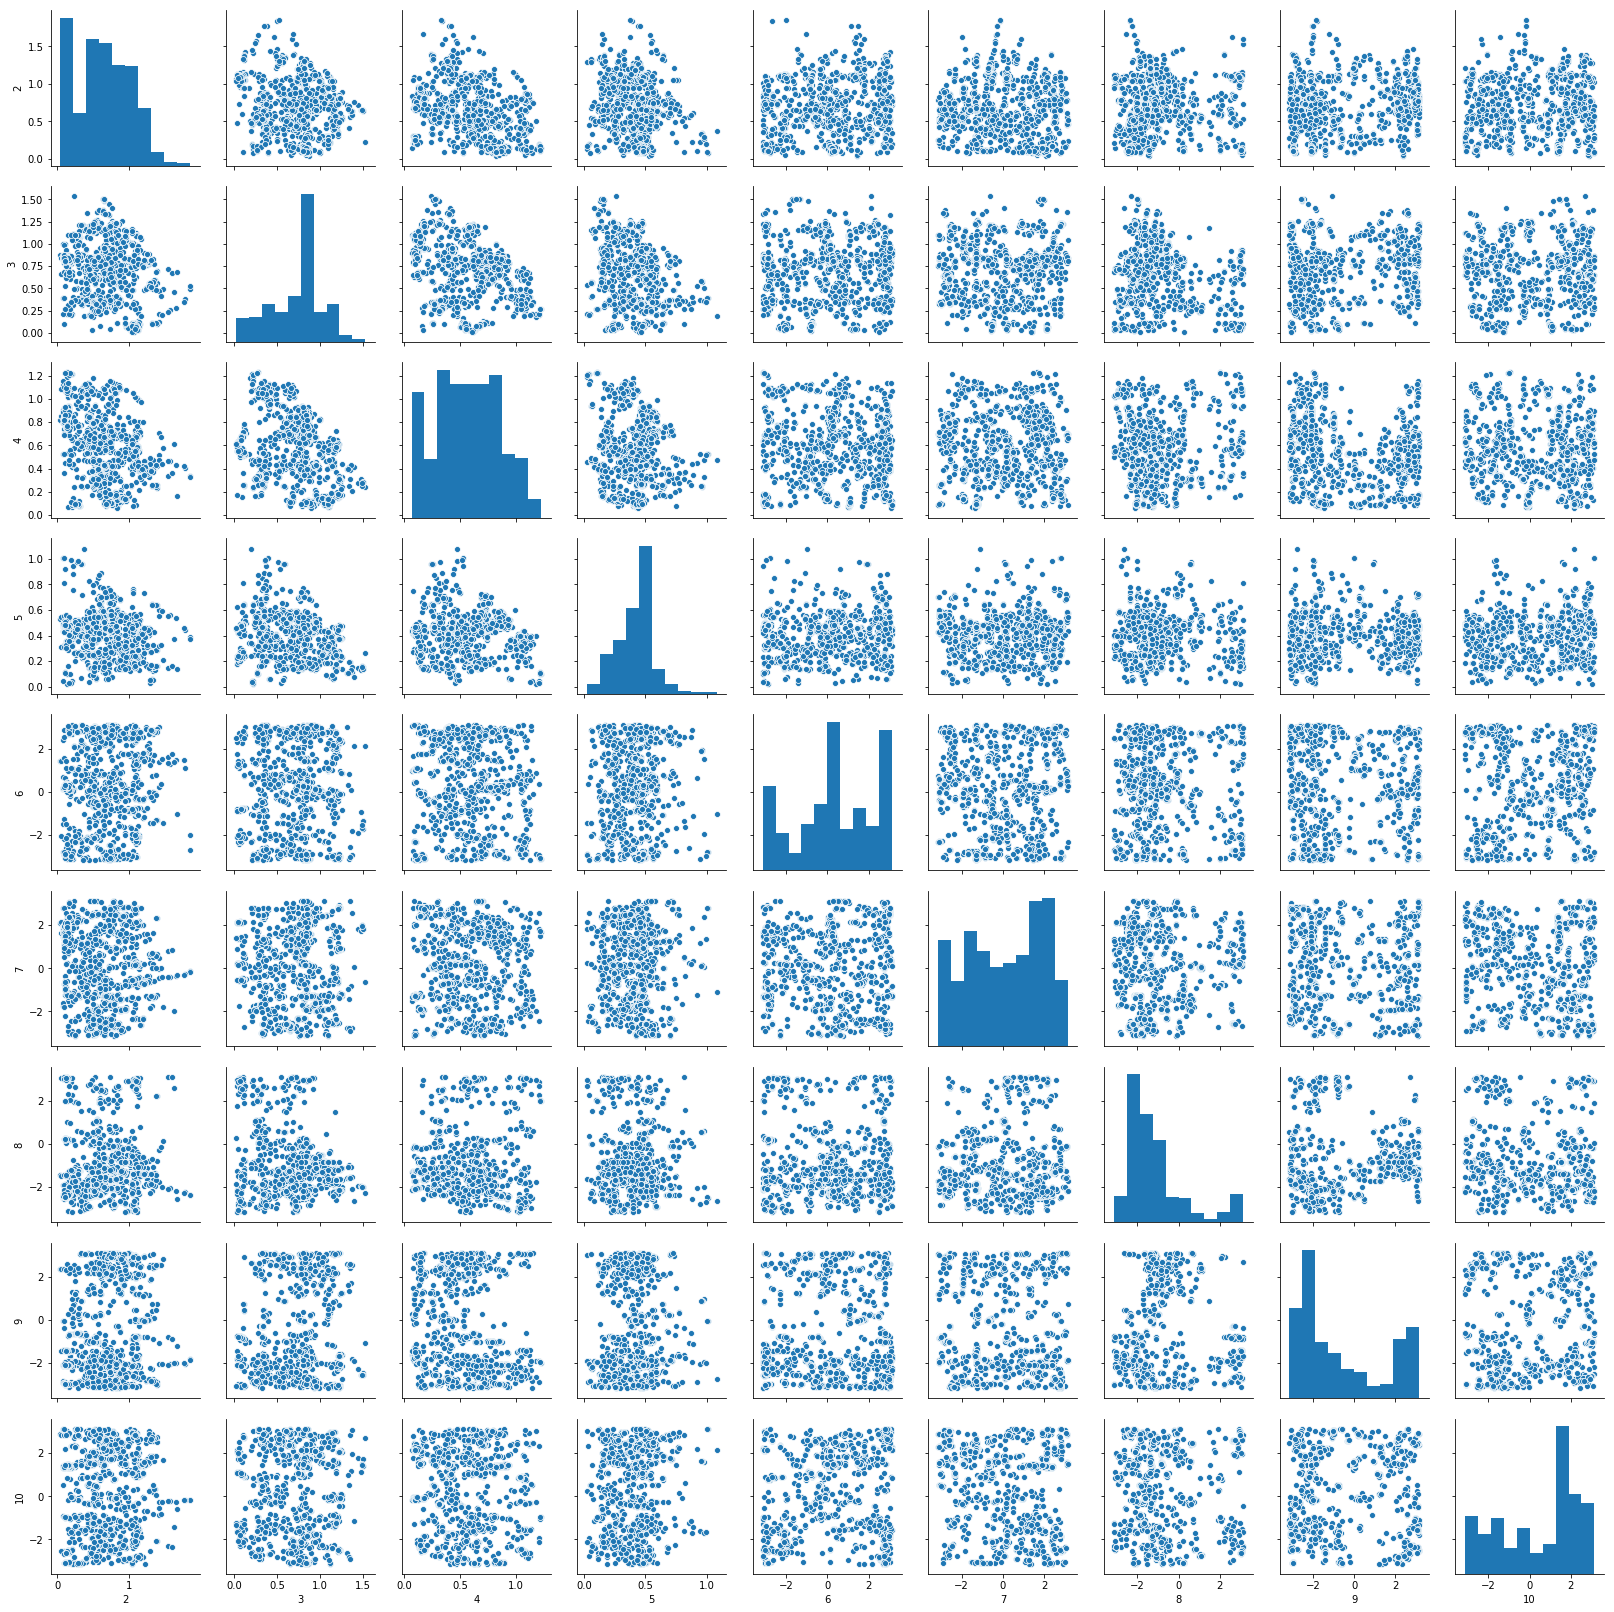

In [236]:
sns.pairplot(pd.DataFrame(result).iloc[:,2:11])

In [166]:
frame = pd.DataFrame(result)
frame.shape

(306, 35)

In [184]:
frame = pd.DataFrame(result)

(array([21.,  6.,  4.,  6.,  5.,  6.,  8.,  6.,  1.,  5.,  1.,  2.,  4.,
         3.,  1.,  8.,  3.,  6.,  5.,  7.,  2.,  6.,  4., 10.,  9., 17.,
         7.,  9.,  3.,  4.,  5.,  3.,  1.,  6.,  3.,  4.,  4., 11., 11.,
         3.,  6.,  5.,  9.,  3., 10.,  3.,  9.,  3.,  8., 19.]),
 array([2.05132487e-04, 1.25860698e-01, 2.51516263e-01, 3.77171828e-01,
        5.02827393e-01, 6.28482958e-01, 7.54138523e-01, 8.79794088e-01,
        1.00544965e+00, 1.13110522e+00, 1.25676078e+00, 1.38241635e+00,
        1.50807191e+00, 1.63372748e+00, 1.75938304e+00, 1.88503861e+00,
        2.01069417e+00, 2.13634974e+00, 2.26200530e+00, 2.38766087e+00,
        2.51331643e+00, 2.63897200e+00, 2.76462756e+00, 2.89028313e+00,
        3.01593869e+00, 3.14159426e+00, 3.26724982e+00, 3.39290539e+00,
        3.51856095e+00, 3.64421652e+00, 3.76987208e+00, 3.89552765e+00,
        4.02118321e+00, 4.14683878e+00, 4.27249435e+00, 4.39814991e+00,
        4.52380548e+00, 4.64946104e+00, 4.77511661e+00, 4.90077217e+

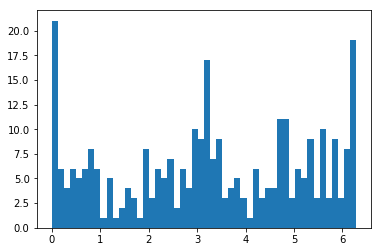

In [218]:
plt.hist(np.mod(frame.iloc[:,4:7].apply(np.diff),2*np.pi).iloc[:,2],bins=50)

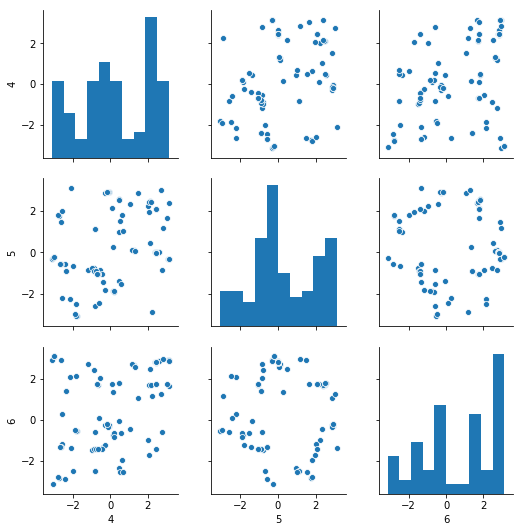

In [192]:
sns.pairplot(frame[[sum(x)==1 for x in check]].iloc[:,4:7])

In [186]:
frame = pd.DataFrame(result)

check = []
for idx, item in enumerate(frame.iloc[:,7:16].values):
    s = [x!=1 for x in item]
    check.append(s)

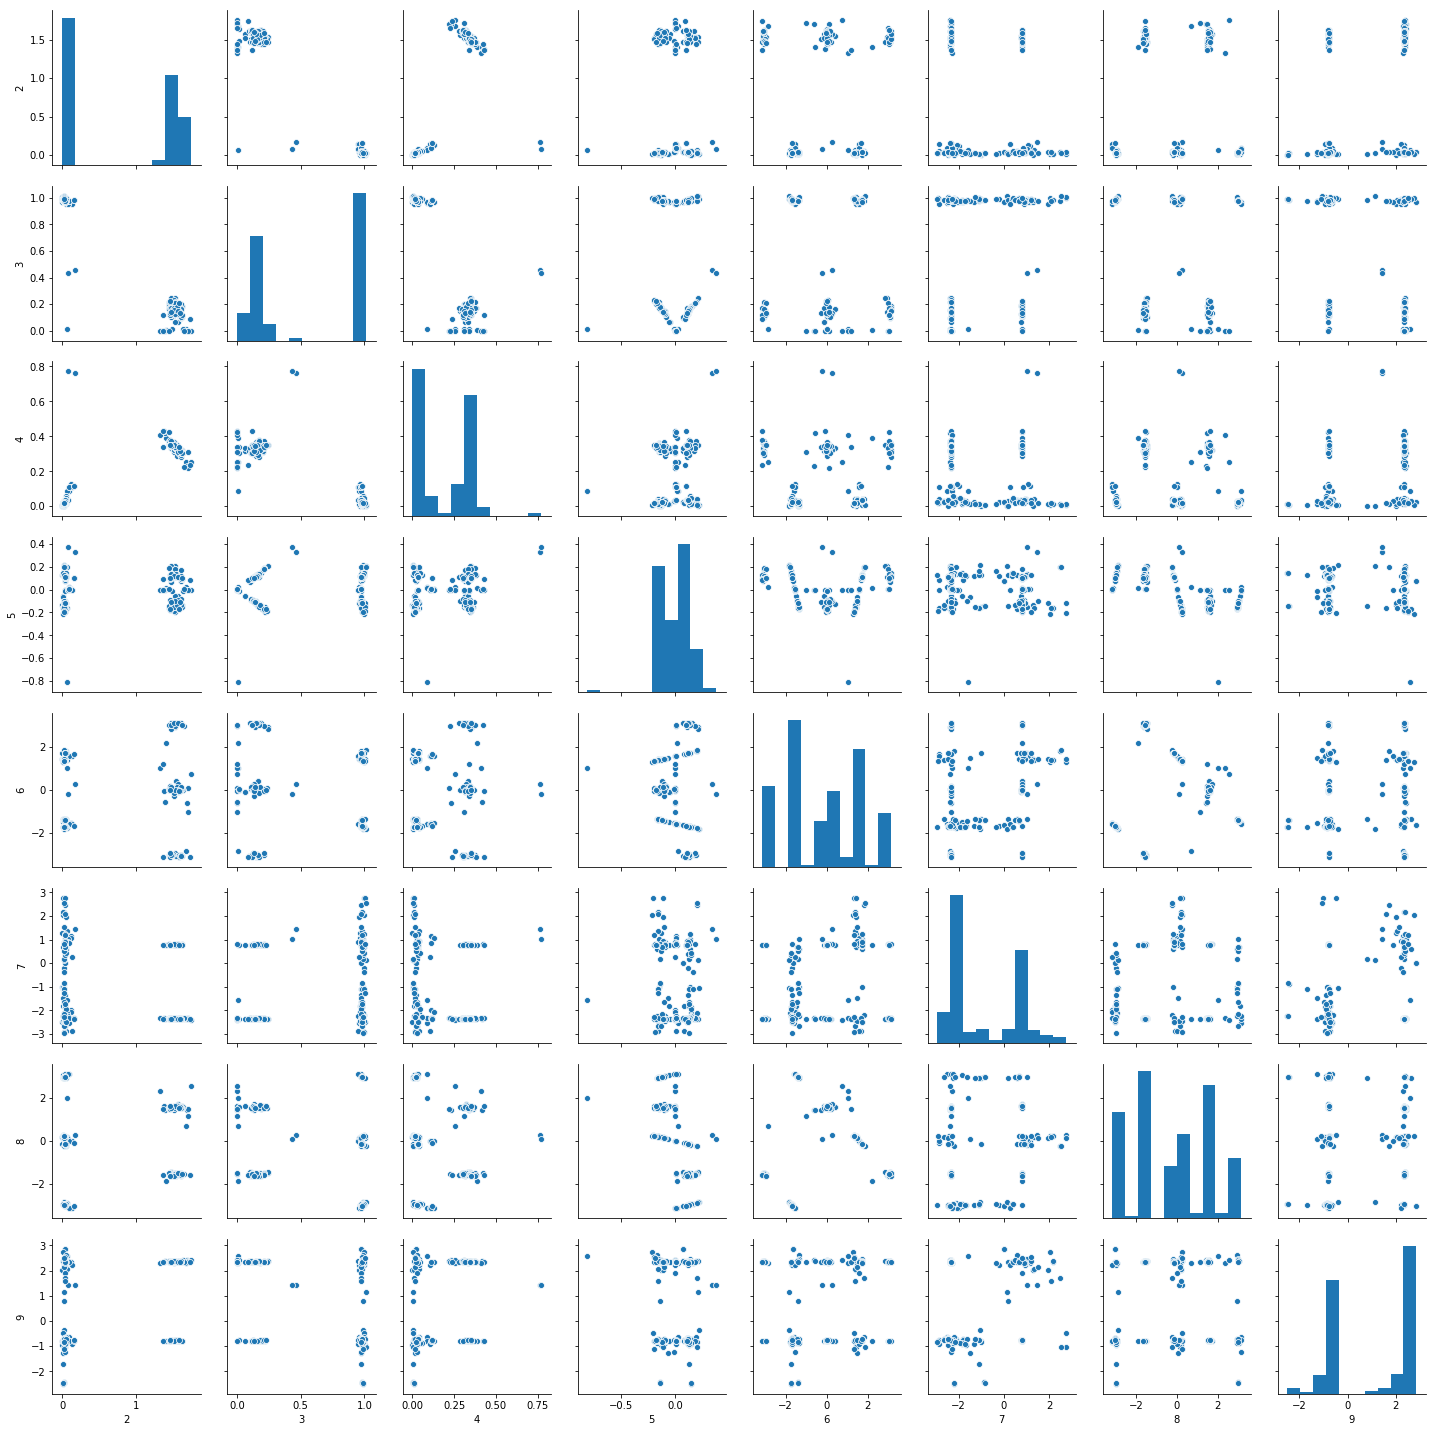

In [154]:
sns.pairplot(frame[[sum(x)==6 for x in check]].iloc[:,2:10])

# Fourteen

In [2]:
fourteen = Chem.SDMolSupplier("fourteen.sdf")

In [4]:
result = []
smarts = Chem.MolFromSmarts("[C;R](=O)[O,N;R]")
for idx, mol in enumerate(fourteen):
    bonds = []
    matches = mol.GetSubstructMatches(smarts)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==14:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                check = [(mat[0] in ringloop) & (mat[2] in ringloop) for mat in matches]
                torsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%14,(i+1)%14,(i+2)%14,(i+3)%14]]) for i in range(14) ]
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*torsion, any(check)))

In [5]:
frame = pd.DataFrame(result)

check = []
for idx, item in enumerate(frame.iloc[:,12:26].values):
    s = [x!=1 for x in item]
    check.append(s)

In [65]:
keep = frame[[sum(x)==2 for x in check]]

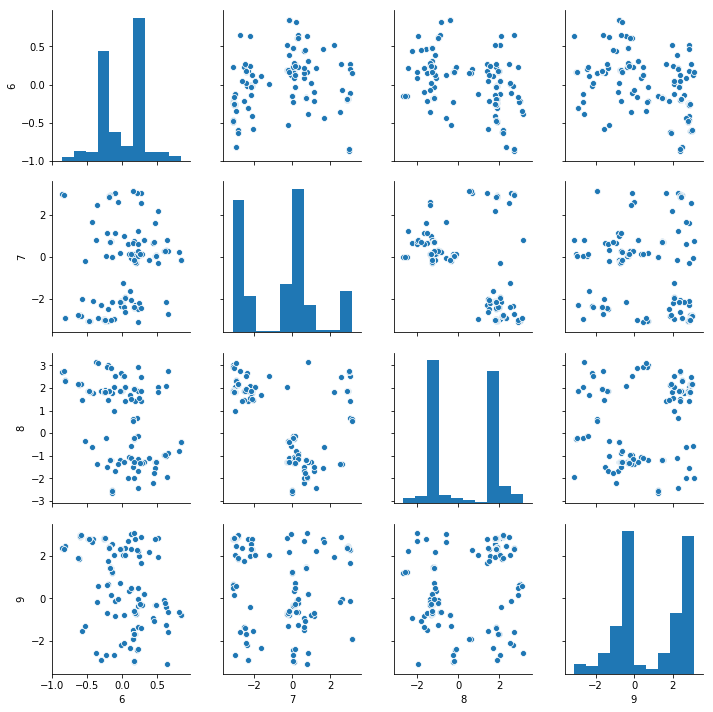

In [86]:
sns.pairplot(keep[np.mod(keep.iloc[:,7]-keep.iloc[:,8],np.pi*2)<4].iloc[:,6:10])

(array([  4.,  15.,   3.,   2.,   0.,   1.,   1.,  63.,   4.,  23.,  68.,
        151.,   1.,   0.,  26.,   2.,   5.,  16.,   4.,   7.,   6.,   4.,
          1.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,   3.,   0.,
          1.,   1.,   0.,   1.,   1.,   0.,   1.,   2.,   0.,   1.,   0.,
          1.,   1.,   2.,   3.,   4.,   7.]),
 array([0.10665279, 0.22974908, 0.35284536, 0.47594165, 0.59903794,
        0.72213423, 0.84523052, 0.96832681, 1.0914231 , 1.21451939,
        1.33761567, 1.46071196, 1.58380825, 1.70690454, 1.83000083,
        1.95309712, 2.07619341, 2.1992897 , 2.32238598, 2.44548227,
        2.56857856, 2.69167485, 2.81477114, 2.93786743, 3.06096372,
        3.18406   , 3.30715629, 3.43025258, 3.55334887, 3.67644516,
        3.79954145, 3.92263774, 4.04573403, 4.16883031, 4.2919266 ,
        4.41502289, 4.53811918, 4.66121547, 4.78431176, 4.90740805,
        5.03050434, 5.15360062, 5.27669691, 5.3997932 , 5.52288949,
        5.64598578, 5.76908207, 5.89217836, 6.

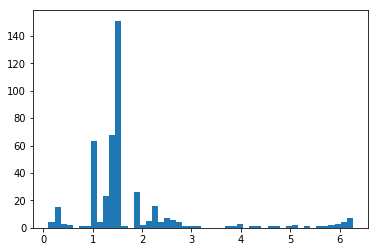

In [80]:
plt.hist(np.mod(keep.iloc[:,7]-keep.iloc[:,8],np.pi*2),bins=50)

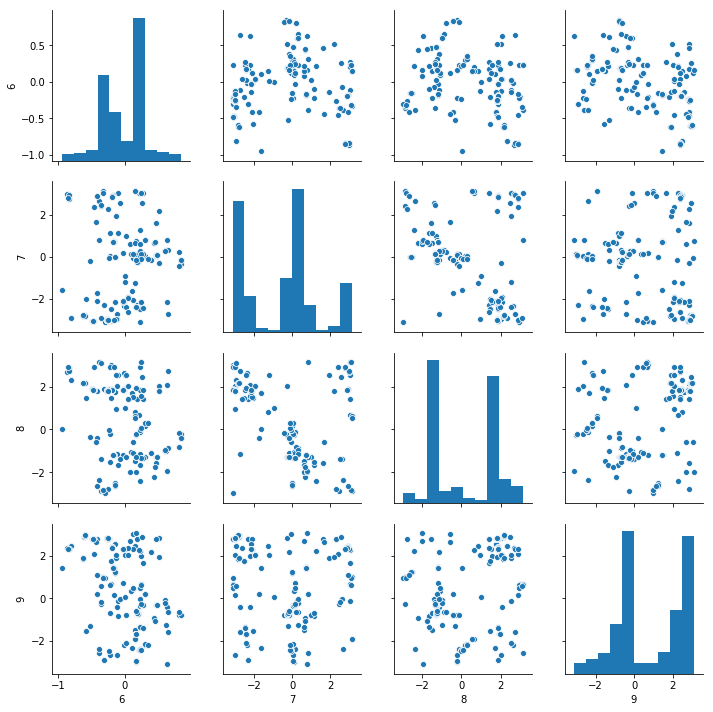

In [74]:
sns.pairplot(keep.iloc[:,6:10])

In [17]:
k1 = keep[(keep.iloc[:,-1])==True]

In [42]:
k2 = k1[(k1.iloc[:,1:6].apply(np.square).sum(axis=1)>5.5) & (k1.iloc[:,1:6].apply(np.square).sum(axis=1)<8)]

In [45]:
len(k2)

294

(array([  2.,   1.,   3., 190.,  22.,   5.,   4.,  59.,   5.,   3.]),
 array([5.50650719, 5.75496188, 6.00341658, 6.25187127, 6.50032596,
        6.74878065, 6.99723534, 7.24569003, 7.49414472, 7.74259941,
        7.9910541 ]),
 <a list of 10 Patch objects>)

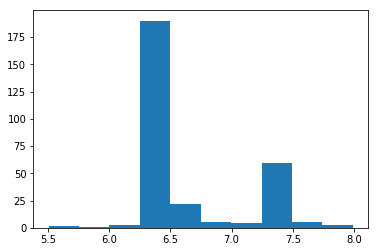

In [46]:
plt.hist(k2.iloc[:,1:6].apply(np.square).sum(axis=1))

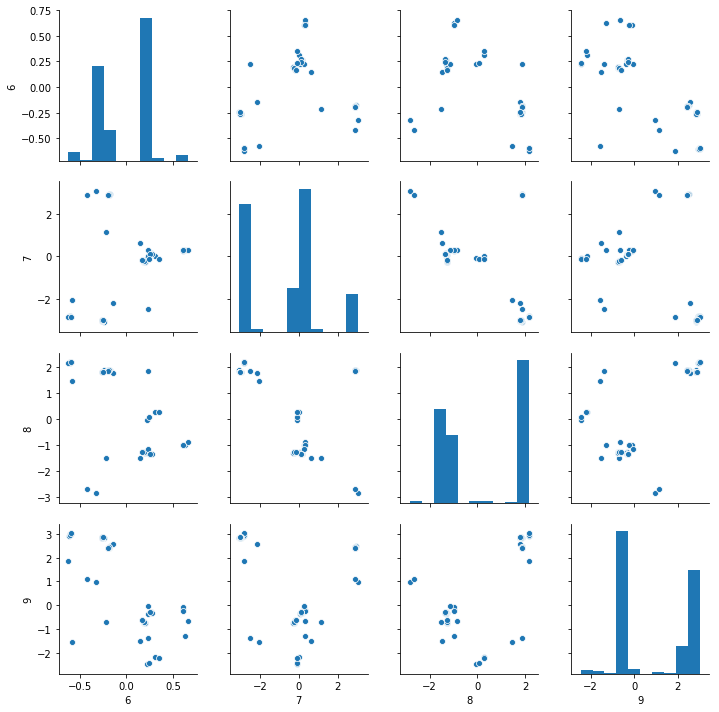

In [47]:
sns.pairplot(k2.iloc[:,6:10])

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 203.,   5.,  12.,
         10.,  52.,   0.,   1.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          4.,   0.,   0.,   0.,   1.,   1.]),
 array([-3.80017674, -3.65960741, -3.51903808, -3.37846876, -3.23789943,
        -3.09733011, -2.95676078, -2.81619145, -2.67562213, -2.5350528 ,
        -2.39448347, -2.25391415, -2.11334482, -1.97277549, -1.83220617,
        -1.69163684, -1.55106752, -1.41049819, -1.26992886, -1.12935954,
        -0.98879021, -0.84822088, -0.70765156, -0.56708223, -0.42651291,
        -0.28594358, -0.14537425, -0.00480493,  0.1357644 ,  0.27633373,
         0.41690305,  0.55747238,  0.6980417 ,  0.83861103,  0.97918036,
         1.11974968,  1.26031901,  1.40088834,  1.54145766,  1.68202699,
         1.82259631,  1.96316564,  2.10373497,  2.24430429,  2.38487362,
 

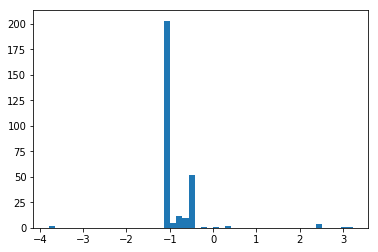

In [52]:
plt.hist(k2.iloc[:,8]-k2.iloc[:,9],bins=50)

In [76]:
x = np.arange(-np.pi,np.pi,0.05)
y1 = np.mod(2*x,2*np.pi)
y2 = np.mod(x+np.pi/2,np.pi*2)
y3 = np.mod(2*x+np.pi/2,np.pi*2)
y4 = np.mod(x+np.pi*135/180,np.pi*2)

In [374]:
qq.iloc[k].iloc[50:90]

0         1         2         3         4         5    6    7    8   \
408  321  0.767415  0.859857 -0.251649 -2.286794  2.012792  1.0  1.0  1.0   
411  324  0.977042  0.588956  0.335027  1.030333  2.139187  1.0  1.0  1.0   
414  327  1.035493  0.647819 -0.320790  0.183754  0.153779  1.0  1.0  1.0   
420  333  0.527716  0.432651  0.399212 -2.938809 -0.216152  1.0  1.0  1.0   
422  335  1.027531  0.629151  0.368446  1.656888 -0.652552  1.0  1.0  1.0   
440  344  1.019909  0.606932  0.348710 -0.066193  1.558436  1.0  1.0  1.0   
452  352  1.553408  0.025258  0.018507  2.980125  1.336102  1.0  1.0  1.0   
453  353  0.000214  0.890176  0.000066 -1.789448  1.992030  1.0  1.0  1.0   
465  362  0.926703  0.001226  0.000990 -1.568315 -1.837461  1.0  1.0  1.0   
480  372  1.000401  0.510248  0.420666  1.290370 -0.880419  1.0  1.0  1.0   
490  381  0.293921  0.020173 -0.797254  0.448497 -1.430867  1.0  1.0  1.0   
491  381  0.389258  0.011924 -0.771972  1.123573  0.387100  1.0  1.0  1.0   
497  387  0.892945  0.652930  0.268987  2.033076  2.576350  1.0  1.0  1.0   
498  388  1.016359  0.629364  0.224855 -1.359461  1.090463  1.0  1.0  1.0   
506  393  0.691870  0.794388  0.276225 -0.450885 -1.962391  1.0  1.0  1.0   
515  402  0.056743  0.010965 -0.804629 -0.655245 -2.419810  1.0  1.0  1.0   
517  404  1.019179  0.614371  0.323301 -3.139187 -0.069419  1.0  1.0  1.0   
519  406  1.265433  0.003957 -0.059285  1.149479  1.100452  1.0  1.0  1.0   
520  406  1.070904  0.074476 -0.082118  0.852044  2.155902  1.0  1.0  1.0   
522  408  1.028182  0.624045 -0.372992 -0.002340 -0.029447  1.0  1.0  1.0   
528  414  0.563971  0.907105 -0.181803 -2.588735  1.867839  1.0  1.0  1.0   
531  417  1.011376  0.650058  0.312268 -0.390916 -1.727269  1.0  1.0  1.0   
532  418  0.996253  0.117435 -0.463570 -0.864262 -0.618073  1.0  1.0  1.0   
537  423  1.047441  0.612069 -0.362121  3.013089  1.512686  1.0  1.0  1.0   
541  427  0.960654  0.616553 -0.357423  1.593142  0.786448  1.0  1.0  1.0   
542  428  0.912944  0.682528 -0.292557  2.891364  1.319966  1.0  1.0  1.0   
543  429  0.324562  0.040273 -0.803790  0.972776 -2.332969  1.0  1.0  1.0   
556  439  0.912494  0.711372  0.311394 -0.294231  1.318992  1.0  1.0  1.0   
560  443  1.599029  0.000109  0.133855 -0.856211  2.665254  1.0  1.0  1.0   
561  444  0.912317  0.702755  0.313307  1.887081  2.609477  1.0  1.0  1.0   
564  447  0.953150  0.000220  0.000318  1.571111 -1.668195  1.0  1.0  1.0   
597  469  1.042792  0.615164  0.365135  1.699246  2.409731  1.0  1.0  1.0   
602  474  0.766217  0.740376 -0.325974 -2.496059  1.922059  1.0  1.0  1.0   
604  476  1.039329  0.608594  0.365635 -0.140610 -1.633865  1.0  1.0  1.0   
611  482  0.478728  0.042789  0.809047 -0.535167  1.545144  1.0  1.0  1.0   
612  483  0.421675  0.017786 -0.827299 -2.366442 -2.781759  1.0  1.0  1.0   
613  484  1.345160  0.287289  0.135207 -1.471848 -2.256624  1.0  1.0  1.0   
614  485  0.566122  0.033167 -0.749430 -2.584258 -0.201663  1.0  1.0  1.0   
617  488  1.047026  0.611780 -0.362960 -1.562815  2.407302  1.0  1.0  1.0   
636  496  0.008499  0.962736  0.000660  1.755849  1.964208  1.0  1.0  1.0   

      9  ...   12   13  14  15 16 17 18 19 20 21  
408  1.0 ...  1.0  1.0   M   B  P  B  M  M  M  M  
411  1.0 ...  1.0  1.0   B   B  M  B  B  B  M  M  
414  1.0 ...  1.0  1.0   M   B  B  M  M  M  M  M  
420  1.0 ...  1.0  1.0   B   M  M  M  M  M  B  B  
422  1.0 ...  1.0  1.0   B   P  B  M  M  M  M  M  
440  1.0 ...  1.0  1.0   B   B  M  M  M  M  M  M  
452  1.0 ...  1.0  1.0   M   M  M  B  B  M  M  M  
453  1.0 ...  1.0  1.0   B   B  M  M  B  B  M  M  
465  1.0 ...  1.0  1.0   M   M  B  M  M  M  B  M  
480  1.0 ...  1.0  1.0   B   B  M  M  B  P  B  B  
490  1.0 ...  1.0  1.0   M   B  B  B  M  M  M  M  
491  1.0 ...  1.0  1.0   B   M  M  M  M  M  B  B  
497  1.0 ...  1.0  1.0   B   B  M  M  B  B  B  M  
498  1.0 ...  1.0  1.0   B   B  M  M  P  B  B  M  
506  1.0 ...  1.0  1.0   M   M  M  M  B  M  M  M  
515  1.0 ...  1.0  1.0   B   P  

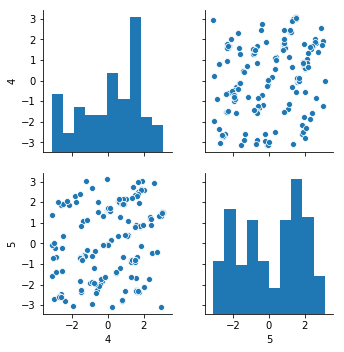

In [362]:
sns.pairplot(qq.iloc[k,4:6])

In [268]:
y3 = 1.06556925*qq.iloc[k,1]*np.cos(qq.iloc[k,2]+4*np.pi/5) + 1.45228565*qq.iloc[k,1]*np.sin(qq.iloc[k,2]+4*np.pi/5) -0.000767584
#y3 = 1.06652924*qq.iloc[k,1]*np.cos(qq.iloc[k,2]) + 1.46343720*qq.iloc[k,1]*np.sin(qq.iloc[k,2]) + 2.45539702e-04

In [315]:
e = np.column_stack([np.ones(len(y3)),y3])

In [316]:
xtx2 = np.linalg.inv(np.matmul(np.transpose(e),e))
xty = np.matmul(np.transpose(e),w)
r=  np.matmul(xtx2,xty)

In [281]:
keep = []
for idx, item in enumerate(qq.iloc[:,18].values):
    for x in item:
        if x[0]==1:
            keep.append((idx,*qq.iloc[idx,[1,2]].values.tolist(),x[1]))
    

In [282]:
w = pd.DataFrame(keep)

In [109]:
w1 = -7.67584045e-04 + 1.06556925*w.iloc[:,1]*np.cos(w.iloc[:,2]+4*np.pi/5) + 1.45228565*w.iloc[:,1]*np.sin(w.iloc[:,2]+4*np.pi/5)

In [110]:
w2 = np.array([np.ones(len(w1)),w1.values]).transpose()

In [111]:
y1 = w.iloc[:,3].values

In [115]:
xtx = np.linalg.inv(np.matmul(np.transpose(w2),w2))
xty = np.matmul(np.transpose(w2),y1)

np.matmul(xtx,xty)

array([ 0.0483072 , -0.13607817])

In [119]:
r =  0.0483072-0.1361*w2

In [258]:
result = []
for idx, mol in enumerate(peptide):
    bonds = []
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==12:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                torsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%12,(i+1)%12,(i+2)%12,(i+3)%12]]) for i in range(12) ]
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*torsion))


In [282]:
a = pd.DataFrame(result)

k = []
for idx, i in enumerate(a.iloc[:,22:34].values):
    if list(i)==["M","M","M","M","M","M","M","M","M","M","M","M"]:
        k.append(idx)
        
b = a.iloc[k,:].reset_index(drop=True)

In [292]:
k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,10:22].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

In [416]:
pep = pd.read_csv("data/cyclic_peptide_2.csv")

In [500]:
cc1 = []
cc2 = []
for idx, item in enumerate(pep[["P1","P2","P3","P4"]].values):
    if list(item)==["C","C","C","C"]:
        cc1.append(idx)
    elif list(item) in [["C","C","C","T"],["C","T","C","C"],["C","C","T","C"]]:
        cc2.append(idx)

In [ ]:
k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,3:7].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

In [67]:
a = pd.DataFrame(result)

k = []
for idx, i in enumerate(a.iloc[:,8:13].values):
    if list(i)==["M","M","M","M","M"]:
        k.append(idx)
        
b = a.iloc[k,:].reset_index(drop=True)

k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,3:7].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

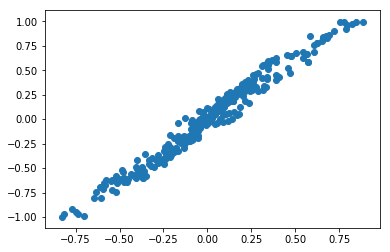

In [45]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]) + a.iloc[k0,1]*np.sin(a.iloc[k0,2])
t2 = a.iloc[k0,13]
plt.scatter(t1,t2)

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]+4*np.pi/5) + a.iloc[k0,1]*np.sin(a.iloc[k0,2]+4*np.pi/5)
t2 = a.iloc[k0,14]
plt.scatter(t1,t2)
plt.show()

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]+8*np.pi/5) + a.iloc[k0,1]*np.sin(a.iloc[k0,2]+8*np.pi/5)
t2 = a.iloc[k0,15]
plt.scatter(t1,t2)

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]+12*np.pi/5) + a.iloc[k0,1]*np.sin(a.iloc[k0,2]+12*np.pi/5)
t2 = a.iloc[k0,16]
plt.scatter(t1,t2)
plt.show()

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]+16*np.pi/5) + a.iloc[k0,1]*np.sin(a.iloc[k0,2]+16*np.pi/5)
t2 = a.iloc[k0,17]
plt.scatter(t1,t2)
plt.show()

In [184]:
a = pd.DataFrame(result)

k = []
for idx, i in enumerate(a.iloc[:,10:16].values):
    if list(i)==["M","M","M","M","M","M"]:
        k.append(idx)
        
b = a.iloc[k,:].reset_index(drop=True)

k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,4:10].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

(array([  5., 481.,  85.,  47.,  13.,  21.,  24.,  54., 223., 317.]),
 array([-1.42534239, -1.16060662, -0.89587084, -0.63113506, -0.36639929,
        -0.10166351,  0.16307226,  0.42780804,  0.69254382,  0.95727959,
         1.22201537]),
 <a list of 10 Patch objects>)

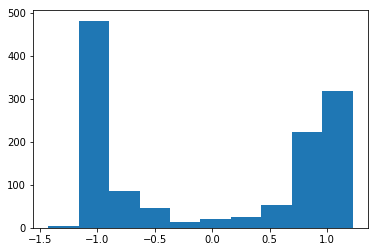

In [185]:
plt.hist(b.iloc[k0,:][16])

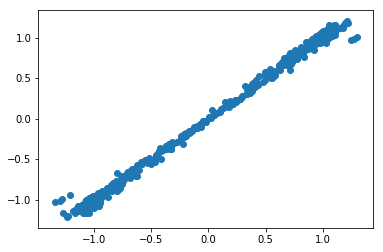

In [247]:
t1 = -0.047*b.iloc[k0,1]*np.cos(b.iloc[k0,3]+4*np.pi/3) + 1.48*b.iloc[k0,1]*np.sin(b.iloc[k0,3]+4*np.pi/3) + 1.74*b.iloc[k0,2]
t2 = b.iloc[k0,18]
plt.scatter(t1,t2)

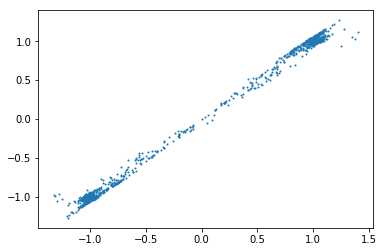

In [256]:
t1 = -0.038*b.iloc[k0,1]*np.cos(b.iloc[k0,3]+6*np.pi/3) + 1.587*b.iloc[k0,1]*np.sin(b.iloc[k0,3]+6*np.pi/3) - 1.78*b.iloc[k0,2]
t2 = b.iloc[k0,19]
plt.scatter(t1,t2,s=1)

In [396]:
a1 = b.iloc[k0,1]*np.cos(b.iloc[k0,6]+2*np.pi*2/12)
b1 = b.iloc[k0,1]*np.sin(b.iloc[k0,6]+2*np.pi*2/12)
c1 = b.iloc[k0,2]*np.cos(b.iloc[k0,7]+2*np.pi*3/12)
d1 = b.iloc[k0,2]*np.sin(b.iloc[k0,7]+2*np.pi*3/12)
e1 = b.iloc[k0,3]*np.cos(b.iloc[k0,8]+2*np.pi*4/12)
f1 = b.iloc[k0,3]*np.sin(b.iloc[k0,8]+2*np.pi*4/12)
g1 = b.iloc[k0,4]*np.cos(b.iloc[k0,9]+2*np.pi*5/12)
h1 = b.iloc[k0,4]*np.sin(b.iloc[k0,9]+2*np.pi*5/12)
i1 = b.iloc[k0,5]
Y = np.array(b.iloc[k0,36])

In [568]:
a1 = b.iloc[k0,1]*np.cos(b.iloc[k0,6])
b1 = b.iloc[k0,1]*np.sin(b.iloc[k0,6])
c1 = b.iloc[k0,2]*np.cos(b.iloc[k0,7])
d1 = b.iloc[k0,2]*np.sin(b.iloc[k0,7])
e1 = b.iloc[k0,3]*np.cos(b.iloc[k0,8])
f1 = b.iloc[k0,3]*np.sin(b.iloc[k0,8])
g1 = b.iloc[k0,4]*np.cos(b.iloc[k0,9])
h1 = b.iloc[k0,4]*np.sin(b.iloc[k0,9])
i1 = b.iloc[k0,5]
Y = np.array(b.iloc[k0,34])

In [564]:
a1 = b.iloc[k0,1]*np.cos(b.iloc[k0,6]+11*2*np.pi*2/12)
b1 = b.iloc[k0,1]*np.sin(b.iloc[k0,6]+11*2*np.pi*2/12)
c1 = b.iloc[k0,2]*np.cos(b.iloc[k0,7]+11*2*np.pi*3/12)
d1 = b.iloc[k0,2]*np.sin(b.iloc[k0,7]+11*2*np.pi*3/12)
e1 = b.iloc[k0,3]*np.cos(b.iloc[k0,8]+11*2*np.pi*4/12)
f1 = b.iloc[k0,3]*np.sin(b.iloc[k0,8]+11*2*np.pi*4/12)
g1 = b.iloc[k0,4]*np.cos(b.iloc[k0,9]+11*2*np.pi*5/12)
h1 = b.iloc[k0,4]*np.sin(b.iloc[k0,9]+11*2*np.pi*5/12)
i1 = b.iloc[k0,5]
Y = np.array(b.iloc[k0,45])

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,3]+5*np.pi/12) + a.iloc[k0,2]
t2 = a.iloc[k0,20]
plt.scatter(t1,t2)

In [93]:
def fixzero(x):
    x_ = np.array([0.0]) if np.allclose(0,x, rtol=1e-06, atol=1e-08) else x
    return x_


def GetRingPuckerCoords(displacement,N):
    """
    Compute Ring Pucker Parameters
    
    Input:

    coordinates: array
    
    Return:

    qs: puckering amplitude (q_i>=0 for all i)
    
    angle: angle defined in 0<= phi_i <= 2pi 

    """

    z = displacement
    if N>4 and N<=20: # In our analysis, we fit it to be smaller than 16.
        if (N%2 == 0): # N even
            m = range(2,int((N/2)))
            cos_component = [np.dot(z,np.cos(2*np.pi*k*np.arange(0,N)/N)) for k in m]
            sin_component = [np.dot(z,np.sin(2*np.pi*k*np.arange(0,N)/N)) for k in m]
            qcos = fixzero(np.sqrt(2/N)*np.array(cos_component))
            qsin = fixzero(-np.sqrt(2/N)*np.array(sin_component))
            q = np.sqrt(qsin**2 + qcos**2)
            amplitude = np.append(q, (1/np.sqrt(N))*np.dot(z,np.cos(np.arange(0,N)*np.pi)).sum()).tolist()
            angle = np.arctan2(qsin,qcos).tolist()
        else: # N odd
            m = range(2,int((N-1)/2)+1)
            cos_component = [np.dot(z,np.cos(2*np.pi*k*np.arange(0,N)/N)) for k in m]
            sin_component = [np.dot(z,np.sin(2*np.pi*k*np.arange(0,N)/N)) for k in m]
            qcos = fixzero(np.sqrt(2/N)*np.array(cos_component))
            qsin = fixzero(-np.sqrt(2/N)*np.array(sin_component))
            amplitude = np.sqrt(qsin**2 + qcos**2).tolist()
            angle = np.arctan2(qsin,qcos).tolist()
    else:
        print("Ring Size is too big or too small")
    return amplitude, angle


In [94]:
GetRingPuckerCoords(dis,6)

([0.4235599999999999, 0.3622790000000001], [-2.5788809999999995])

In [112]:
GetRingPuckerCoords([dis[x%6] for x in range(2,8)],6)

([0.4235599999999998, 0.3622790000000002], [1.6099092047863912])

In [55]:
0.2204751228718341+2.2927990000000005

2.5132741228718345

In [113]:
(1.6099092047863912+2.5788809999999995)/np.pi

1.3333333333333333

In [99]:
2*np.pi/3

2.0943951023931953

In [38]:
np.pi*4/5

2.5132741228718345

In [ ]:
g1 = sns.pairplot(mono_five.iloc[mono_single][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5","1"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5","1"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_single_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_five.iloc[poly_single][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5","1"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5","1"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_single_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_five.iloc[mono_one][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5])
g1.axes[0,0].set_yticks([0,0.5])
g1.axes[1,0].set_xticks([0,0.5])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_one_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_five.iloc[poly_one][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5])
g1.axes[0,0].set_yticks([0,0.5])
g1.axes[1,0].set_xticks([0,0.5])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_one_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_five.iloc[mono_two][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5",r"1"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5",r"1"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_two_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_five.iloc[poly_two][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5",r"1"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5",r"1"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_two_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [63]:
six = pd.read_csv("six.csv")
monocyclic = []
polycyclic = []
for idx, item in enumerate(six[["A0","A1","A2","A3","A4","A5"]].values):
    if list(item)==["M","M","M","M","M","M"]:
        monocyclic.append(idx)
    else:
        polycyclic.append(idx)
        
mono_six = six.iloc[monocyclic].reset_index(drop=True)
poly_six = six.iloc[polycyclic].reset_index(drop=True)

mono_single = []
mono_one = []
mono_two = []
for idx, item in enumerate(mono_six[["B0","B1","B2","B3","B4","B5"]].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        mono_single.append(idx)
    elif sum(check)==1:
        mono_one.append(idx)
    else:
        mono_two.append(idx)

poly_single = []
poly_one = []
poly_two = []
for idx, item in enumerate(poly_six[["B0","B1","B2","B3","B4","B5"]].values):
    check = [x==1.5 or x==2.0 for x in list(item)]
    if sum(check)==0:
        poly_single.append(idx)
    elif sum(check)==1:
        poly_one.append(idx)
    else:
        poly_two.append(idx)

In [ ]:
g1 = sns.pairplot(mono_six.iloc[mono_single][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_single_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_six.iloc[poly_single][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_single_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_six.iloc[mono_one][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_one_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_six.iloc[poly_one][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_one_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_six.iloc[mono_two][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_xlim(-1,1)
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_two_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_six.iloc[poly_two][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_two_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
seven = pd.read_csv("seven.csv")

In [ ]:
monocyclic = []
polycyclic = []
for idx, item in enumerate(seven[["A0","A1","A2","A3","A4","A5","A6"]].values):
    if list(item)==["M","M","M","M","M","M","M"]:
        monocyclic.append(idx)
    else:
        polycyclic.append(idx)
        
mono_seven = seven.iloc[monocyclic].reset_index(drop=True)
poly_seven = seven.iloc[polycyclic].reset_index(drop=True)

mono_single = []
mono_one = []
mono_two = []
for idx, item in enumerate(mono_seven[["B0","B1","B2","B3","B4","B5","B6"]].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        mono_single.append(idx)
    elif sum(check)==1:
        mono_one.append(idx)
    else:
        mono_two.append(idx)

poly_single = []
poly_one = []
poly_two = []
for idx, item in enumerate(poly_seven[["B0","B1","B2","B3","B4","B5","B6"]].values):
    check = [x==1.5 or x==2.0 for x in list(item)]
    if sum(check)==0:
        poly_single.append(idx)
    elif sum(check)==1:
        poly_one.append(idx)
    else:
        poly_two.append(idx)

In [ ]:
g1 = sns.pairplot(mono_seven.iloc[mono_single][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=30))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_single_seven.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_seven.iloc[poly_single][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=30))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_single_seven.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_seven.iloc[mono_one][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=10))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_one_seven.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_seven.iloc[poly_one][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=30))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_one_seven.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_seven.iloc[mono_two][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=20))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_two_seven.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_seven.iloc[poly_two][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_two_seven.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# Eight
eight = pd.read_csv("eight.csv")

In [ ]:
eight[["q2","q3","q4","phi2","phi3"]]

In [ ]:
g1 = sns.pairplot(six1.iloc[a2][["q3","phi2"]], plot_kws=dict(s=15),diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xlim(-0.6,0.6)
g1.axes[0,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,0].set_ylim(-0.6,0.6)
g1.axes[0,1].set_ylim(-0.6,0.6)
g1.axes[1,0].set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,1].set_xlim(-np.pi,np.pi)
g1.axes[1,0].set_xlim(-0.6,0.6)
g1.axes[1,0].set_ylim(-np.pi,np.pi)
g1.axes[1,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,1].set_xlim(-np.pi,np.pi)
g1.axes[1,1].set_ylim(-np.pi,np.pi)
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/six_one_M_db.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(six2.iloc[b2][["q3","phi2"]], plot_kws=dict(s=15),diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xlim(-0.6,0.6)
g1.axes[0,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,0].set_ylim(-0.6,0.6)
g1.axes[0,1].set_ylim(-0.6,0.6)
g1.axes[1,0].set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,1].set_xlim(-np.pi,np.pi)
g1.axes[1,0].set_xlim(-0.6,0.6)
g1.axes[1,0].set_ylim(-np.pi,np.pi)
g1.axes[1,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,1].set_xlim(-np.pi,np.pi)
g1.axes[1,1].set_ylim(-np.pi,np.pi)
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/six_one_BP_db.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
qq1 = six1.iloc[a2][np.abs(six1.iloc[a2]["q3"])<0.03].reset_index()
qq2 = six2.iloc[b2][np.abs(six2.iloc[b2]["q3"])<0.03].reset_index()

In [ ]:
q = six2.iloc[b2].reset_index()

In [ ]:
k = []
for item in q[["B0","B1","B2","B3","B4","B5"]].values:
    k.append(sum([x==1.5 for x in item])!=2)
     

In [ ]:
five

In [ ]:
g1 = sns.pairplot(q.iloc[k][["q3","phi2"]],plot_kws=dict(s=15), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xlim(-0.6,0.6)
g1.axes[0,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,0].set_ylim(-0.6,0.6)
g1.axes[0,1].set_ylim(-0.6,0.6)
g1.axes[1,0].set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,1].set_xlim(-np.pi,np.pi)
g1.axes[1,0].set_xlim(-0.6,0.6)
g1.axes[1,0].set_ylim(-np.pi,np.pi)
g1.axes[1,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,1].set_xlim(-np.pi,np.pi)
g1.axes[1,1].set_ylim(-np.pi,np.pi)
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.show()

In [ ]:
ss = []
for idx, item in enumerate(qq[["B0","B1","B2","B3","B4","B5"]].values):
    if sum([x==1.5 for x in item])!=2:
        ss.append(idx)
        

In [ ]:
sns.pairplot(qq.iloc[ss][["q2","q3","phi2"]])

In [ ]:
qq.iloc[ss]

In [ ]:
np.unique(five["idx"]).shape

In [ ]:
mol = Chem.MolFromSmiles("C1CCCCC12CCCCCC2")

In [ ]:
RA.GetRingElement(mol, [5,4,3,2,1])

In [ ]:
ringatom = Chem.MolFromSmarts("[r]")

In [ ]:
def GetRingAtomType(mol, ringidx):
    """
    Input:
    
    mol: rdMol
    
    ringidx: list
    
    Return:
    
    outcome: list
    
    """
    ringatom = Chem.MolFromSmarts("[R]")
    monocyclicatom = Chem.MolFromSmarts("[R1]")
    bicyclicatom = Chem.MolFromSmarts("[R2]")
    ringatom_match = [a for x in mol.GetSubstructMatches(ringatom) for a in x]
    monocyclic_match = [a for x in mol.GetSubstructMatches(monocyclicatom) for a in x]
    bicyclic_match = [a for x in mol.GetSubstructMatches(bicyclicatom) for a in x]
    outcome = []
    for i in ringidx:
        if (i in ringatom_match) and (i in monocyclic_match):
            outcome.append("M")
        elif (i in ringatom_match) and (i in bicyclic_match):
            outcome.append("B")
        elif (i in ringatom_match) and (i not in monocyclic_match) and (i not in bicyclic_match):
            outcome.append("P")
        else:
            outcome.append("NA")
    return outcome

In [ ]:
list(range(2,2))

In [ ]:
[item[1] for item in RA.GetRingBonds(mol, range(6))]

In [ ]:
GetRingAtomType(mol, list(range(8)))

In [ ]:
mol.GetSubstructMatches(ringatom)

In [ ]:
mol.GetSubstructMatches(monocyclicatom)

In [ ]:
mol.GetSubstructMatches(bicyclicatom)

In [ ]:
aromatic = []
aliphatic = []
for row in five.iterrows():
    check = [x==1.5 for x in eval(row[1][2])]
    if all(check):
        aromatic.append(row[1])
    else:
        aliphatic.append(row[1])

In [ ]:
s1 = []
s2 = []
s3 = []
for item in aliphatic:
    check = sum(eval(item[2]))
    if check==5.5:
        tmp = eval(item[1])
        s1.append((tmp[0][0],tmp[1][0]))
    elif check==6:
        tmp = eval(item[1])
        s2.append((tmp[0][0],tmp[1][0]))
    elif check==5:
        tmp = eval(item[1])
        s3.append((tmp[0][0],tmp[1][0]))

In [ ]:
pd.DataFrame(s1)[0].hist(bins=50)
pd.DataFrame(s2)[0].hist(bins=50)
pd.DataFrame(s3)[0].hist(bins=50,alpha=.2)

In [ ]:
#pd.DataFrame(s1)[1].hist(bins=50)
#pd.DataFrame(s2)[1].hist(bins=50)
pd.DataFrame(s3)[0].hist(bins=100)

In [ ]:
sns.pairplot(pd.DataFrame(s1),plot_kws=dict(s=5), diag_kws=dict(bins=50))

In [ ]:
sns.pairplot(pd.DataFrame(single),plot_kws=dict(s=5), diag_kws=dict(bins=50))

In [ ]:
single

# Substituents Orientation

In [ ]:
fluorine = pd.read_csv("data/halogen_f.csv")
chlorine = pd.read_csv("data/halogen_cl.csv")
bromine = pd.read_csv("data/halogen_br.csv")
iodine = pd.read_csv("data/halogen_i.csv")
amine0 = pd.read_csv("data/amine_0.csv")
amine1 = pd.read_csv("data/amine_1.csv")
amine2 = pd.read_csv("data/amine_2.csv")
alkoxy = pd.read_csv("data/alkoxy.csv")
hydroxyl = pd.read_csv("data/hydroxyl.csv")
methyl = pd.read_csv("data/methyl.csv")
ketone = pd.read_csv("data/ketone.csv")
carboxylicacid_0 = pd.read_csv("data/carboxylicacid_0.csv")
carboxylicacid_1 = pd.read_csv("data/carboxylicacid_1.csv")
carboxylicacid_2 = pd.read_csv("data/carboxylicacid_2.csv")
carbonyl = pd.read_csv("data/carbonyl.csv")

In [ ]:
# Substituents
aliphatic = [len(aliphatic_fluorine),len(aliphatic_chlorine),len(aliphatic_bromine), len(aliphatic_iodine), 
             len(aliphatic_alkoxy), len(aliphatic_hydroxyl), len(aliphatic_amine0),len(aliphatic_amine1)
             ,len(aliphatic_amine2), len(aliphatic_methyl), len(aliphatic_ketone), len(aliphatic_carbonyl), len(aliphatic_carboxylicacid0),
            len(aliphatic_carboxylicacid1)]
aromatic = [len(aromatic_fluorine),len(aromatic_chlorine),len(aromatic_bromine), len(aromatic_iodine), 
           len(aromatic_alkoxy), len(aromatic_hydroxyl), len(aromatic_amine0), len(aromatic_amine1),
            len(aromatic_amine2), len(aromatic_methyl), len(aromatic_ketone), len(aromatic_carbonyl), len(aromatic_carboxylicacid0),
           len(aromatic_carboxylicacid1)]
types = ["aliphatic"]*len(aliphatic) + ["aromatic"]*len(aromatic)
name = ["Fluorine","Chlorine","Bromine","Iodine","Alkoxy","Hydroxyl","Tertiary Amine","Secondary Amine","Primary Amine", 
        "Methyl", "Ketone", "Carbonyl","Carboxylic Acid", "Carboxylic"]

dataframe = pd.DataFrame({"Types":types,"Count":aliphatic+aromatic, "Name":name*2})

sns.barplot(x="Name",y="Count", data=dataframe, hue="Types")
plt.yscale("log")
plt.xticks(range(len(name)), name, rotation='vertical')
plt.xlabel("Substituents",size=15)
plt.ylabel("Count",size=15)
plt.legend()
plt.show()

In [ ]:
aromatic_fluorine = fluorine[fluorine["aromatic"]==True]
aliphatic_fluorine = fluorine[fluorine["aromatic"]==False]

aromatic_chlorine = chlorine[chlorine["aromatic"]==True]
aliphatic_chlorine = chlorine[chlorine["aromatic"]==False]

aromatic_bromine = bromine[bromine["aromatic"]==True]
aliphatic_bromine = bromine[bromine["aromatic"]==False]

aromatic_iodine = iodine[iodine["aromatic"]==True]
aliphatic_iodine = iodine[iodine["aromatic"]==False]

aromatic_methyl = methyl[methyl["aromatic"]==True]
aliphatic_methyl = methyl[methyl["aromatic"]==False]

aromatic_alkoxy = alkoxy[alkoxy["aromatic"]==True]
aliphatic_alkoxy = alkoxy[alkoxy["aromatic"]==False]

aromatic_hydroxyl = hydroxyl[hydroxyl["aromatic"]==True]
aliphatic_hydroxyl = hydroxyl[hydroxyl["aromatic"]==False]

aromatic_amine0 = amine0[amine0["aromatic"]==True]
aliphatic_amine0 = amine0[amine0["aromatic"]==False]

aromatic_amine1 = amine1[amine1["aromatic"]==True]
aliphatic_amine1 = amine1[amine1["aromatic"]==False]

aromatic_amine2 = amine2[amine2["aromatic"]==True]
aliphatic_amine2 = amine2[amine2["aromatic"]==False]

aromatic_ketone = ketone[ketone["aromatic"]==True]
aliphatic_ketone = ketone[ketone["aromatic"]==False]

aromatic_carbonyl = carbonyl[carbonyl["aromatic"]==True]
aliphatic_carbonyl = carbonyl[carbonyl["aromatic"]==False]

aromatic_carboxylicacid0 = carboxylicacid_0[carboxylicacid_0["aromatic"]==True]
aliphatic_carboxylicacid0 = carboxylicacid_0[carboxylicacid_0["aromatic"]==False]

aromatic_carboxylicacid1 = carboxylicacid_1[carboxylicacid_1["aromatic"]==True]
aliphatic_carboxylicacid1 = carboxylicacid_1[carboxylicacid_1["aromatic"]==False]

In [ ]:
plt.hist(aromatic_fluorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,1800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_flurine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_chlorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,6000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_chlorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_bromine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,3000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_bromine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_iodine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_iodine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aromatic_fluorine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1250)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_fluorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_chlorine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_chlorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_bromine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_bromine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_iodine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_iodine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aliphatic_fluorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_fluorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_chlorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,200)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_chlorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_bromine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_bromine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_iodine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,50)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_iodine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aliphatic_fluorine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_fluorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_chlorine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,400)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_chlorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_bromine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"-$\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_bromine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_iodine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"-$\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,50)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_iodine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Methyl

In [ ]:
plt.hist(aliphatic_methyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,5000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_methyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_methyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,25000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_methyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_methyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,18000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_methyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_methyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,4000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_methyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Alkoxy and Hydroxyl

In [ ]:
plt.hist(aliphatic_alkoxy["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_alkoxy_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_alkoxy["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,14000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_alkoxy_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_hydroxyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,2000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_hydroxyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_hydroxyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,8000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_hydroxyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()


In [ ]:
plt.hist(aliphatic_alkoxy["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,2500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_alkoxy_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_alkoxy["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,4500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_alkoxy_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_hydroxyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,13000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_hydroxyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_hydroxyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_hydroxyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Amine

In [ ]:
## Aromatic
plt.hist(aromatic_amine0["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,7000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine0_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine1["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,2000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine1_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine2["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,150)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine2_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()


plt.hist(aliphatic_amine0["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine0_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine1["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,250)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine1_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine2["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,150)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine2_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()



In [ ]:
## Aromatic
plt.hist(aromatic_amine0["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,5500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine0_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine1["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine1_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine2["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,300)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine2_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

## Aliphatic
plt.hist(aliphatic_amine0["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine0_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine1["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine1_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine2["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,300)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine2_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Ketone

In [ ]:
plt.hist(aliphatic_ketone["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_ketone_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_ketone["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,9000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_ketone_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aliphatic_ketone["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,5500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_ketone_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_ketone["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_ketone_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Carbonyl

In [ ]:
plt.hist(aliphatic_carbonyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,10000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_carbonyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aliphatic_carbonyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,35000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
#plt.savefig("aliphatic_carbonyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()


In [ ]:
alkoxy = Chem.SDMolSupplier("molecule/f.sdf")
alkoxy_smarts = "[R][F&!R]"
c1 = []
for idx, mol in enumerate(alkoxy):
    bonds = []
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if (len(list(rc.nodes))<20) and (len(list(rc.nodes))>4):
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ox = RA.GetSubstituent(mol, list(rc.nodes), alkoxy_smarts)
                if any(ox):
                    for i in ox:
                        ccoord = RA.Translate(coord)
                        cptmp = RA.GetRingPuckerCoords(ccoord)
                        ohpos = RA.GetRingSubstituentPosition(mol, ringloop, i)
                        b = RA.GetRingBonds(mol, ringloop)
                        c1.append((idx,cptmp,ohpos,b))


In [ ]:
RA.GetRingBonds(mol)

In [ ]:
mol = Chem.MolFromSmiles("c1ccccc1")

In [ ]:
RA.GetRingBonds(mol,list(range(6)))

In [ ]:
plt.hist(mono_five.iloc[mono_single]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,1200)
#plt.savefig("Fig/Macrocycle/mono_single_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_single]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,2500)
#plt.savefig("Fig/Macrocycle/poly_single_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_single]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,600)
#plt.savefig("Fig/Macrocycle/mono_single_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_single]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1400)
#plt.savefig("Fig/Macrocycle/poly_single_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_one]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,1200)
#plt.savefig("Fig/Macrocycle/mono_one_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_one]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,7000)
#plt.savefig("Fig/Macrocycle/poly_one_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_one]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,350)
#plt.savefig("Fig/Macrocycle/mono_one_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_one]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,3000)
#plt.savefig("Fig/Macrocycle/poly_one_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_two]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,15000)
#plt.savefig("Fig/Macrocycle/mono_two_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_two]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,15000)
#plt.savefig("Fig/Macrocycle/poly_two_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_two]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,450)
#plt.savefig("Fig/Macrocycle/mono_two_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_two]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1300)
#plt.savefig("Fig/Macrocycle/poly_two_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()